🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 LIGHTWEIGHT MULTI-SHAPE RL PAINTER

⚡ OPTIMIZATIONS FOR FASTER TRAINING:
  1. Lighter network (3 conv layers instead of 5)
  2. Fewer expert demos (20-40 vs 80-120)
  3. Reduced BC epochs (30-50 vs 80-120)
  4. Reduced RL episodes (300-500 vs 800-1200)
  5. Moderate expert density (2 passes vs 3-4)
  6. Early stopping with patience
  7. Smaller batch sizes and faster convergence

  Expected speedup: 3-5x faster ⚡

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE 1/6: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🔍 Edge Detection: Outline=960px (69.9%), Interior=833px (60.7%)
  ✓ Lightweight Network | LR: 2.0e-03 | BC: 30 | RL: 300

TRAINING: CIRCLE ⭐

📚 Generating Expert Demos for CIRCLE
✓ Generated 20 demos (avg length: 253)
  ✓ Collected 5040 state-action pairs

🎓 Phase 1: BC (30 epochs)
Epoch   0 | Loss: 2.5928 | MSE: 0.2111 | Out: 0.0% | Int: 9.1%
Epoch  10 | Loss: 0.3425 | MSE: 0.2183 | Out: 87.4% | Int: 17.4%
Epoch  20

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/lightweight_results.png'

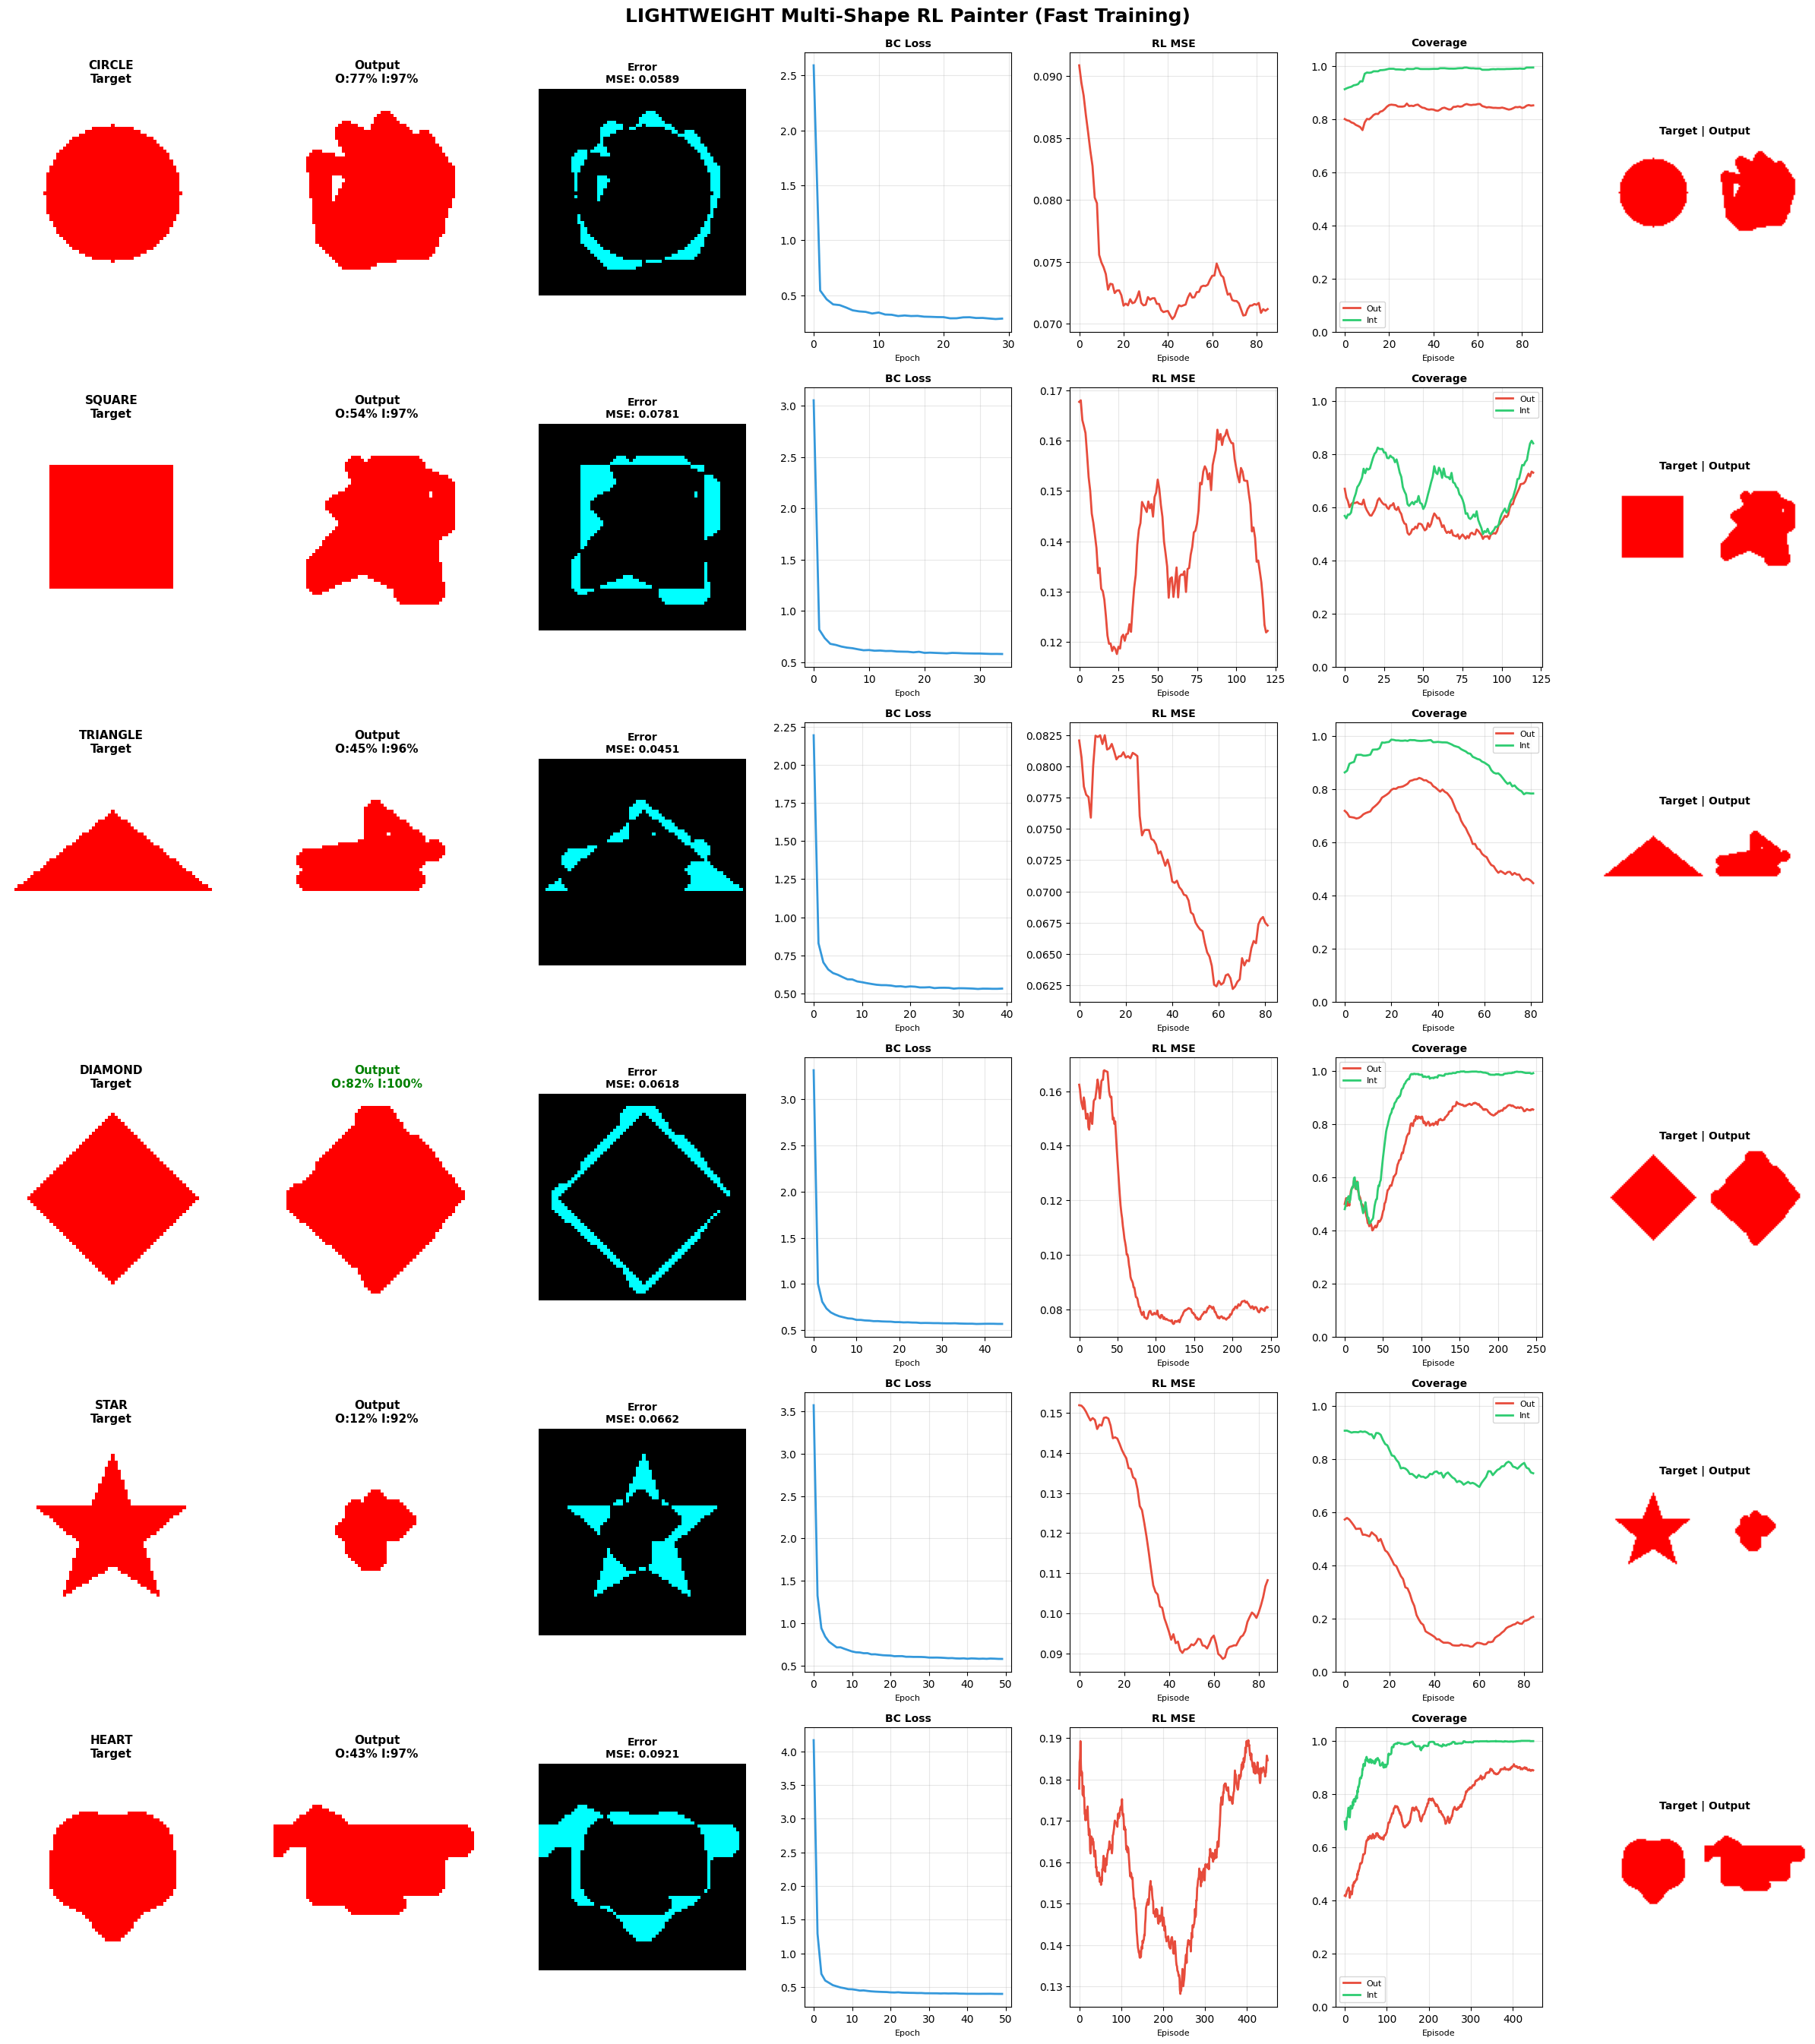

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
from collections import deque

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class ImprovedCoverageDrawingEnv:
    """Enhanced environment with better stroke rendering"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.outline_distance_map = None
        self.interior_distance_map = None
        self.reset()

    def set_target(self, target):
        """Improved edge detection with multiple methods"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Method 1: Morphological edge detection
        eroded = ndimage.binary_erosion(target_mask, iterations=2)
        outline_morph = target_mask & ~eroded
        
        # Method 2: Gradient-based edge detection
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=1.0)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.2
        
        # Combine methods
        self.target_outline = outline_morph | outline_gradient
        
        # Clean up noise
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        
        # Interior
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=5)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Distance maps for reward shaping
        self.outline_distance_map = ndimage.distance_transform_edt(~self.target_outline)
        self.interior_distance_map = ndimage.distance_transform_edt(~self.target_interior)
        
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.previous_outline_cov = 0.0
        self.previous_interior_cov = 0.0
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Enhanced state representation"""
        state = np.zeros((self.canvas_size, self.canvas_size, 10), dtype=np.float32)
        
        # Canvas
        state[:, :, :3] = self.canvas

        # Cursor position
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-5, 6):
            for dx in range(-5, 6):
                if dx*dx + dy*dy <= 25:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Coverage information
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Distance maps (normalized)
        if self.outline_distance_map is not None:
            state[:, :, 6] = np.clip(self.outline_distance_map / 15.0, 0, 1)
            state[:, :, 7] = np.clip(self.interior_distance_map / 15.0, 0, 1)
        
        # Target outline and interior masks
        if self.target_outline is not None:
            state[:, :, 8] = self.target_outline.astype(np.float32)
            state[:, :, 9] = self.target_interior.astype(np.float32)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        """Improved stroke rendering with anti-aliasing"""
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        # Use PIL for smooth rendering
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        # Thicker stroke for better coverage
        draw.line([x1, y1, x2, y2], fill=color, width=7)
        
        # Add endpoint circles for smoother connections
        draw.ellipse([x1-3, y1-3, x1+3, y1+3], fill=color)
        draw.ellipse([x2-3, y2-3, x2+3, y2+3], fill=color)
        
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_outline_cov, prev_interior_cov, _ = self.compute_coverage()

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True, {}

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        curr_outline_cov, curr_interior_cov, _ = self.compute_coverage()
        
        # Track phase transition
        if curr_outline_cov > 0.80 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 200

        info = {
            'outline_progress': curr_outline_cov - prev_outline_cov,
            'interior_progress': curr_interior_cov - prev_interior_cov,
            'outline_cov': curr_outline_cov,
            'interior_cov': curr_interior_cov,
            'phase_complete': self.outline_complete
        }

        return self.get_state(), done, info


class LightweightPolicyNetwork(nn.Module):
    """Lighter architecture for faster training"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # Lighter encoder - only 3 conv layers
        self.conv1 = nn.Conv2d(10, 32, 3, stride=2, padding=1)  # 64->32
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 32->16
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 16->8
        self.bn3 = nn.BatchNorm2d(128)

        flat_size = 128 * 8 * 8

        # Lighter action head
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, self.num_actions)
        )

        # Lighter value head
        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        
        # Encoder
        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        features = x.flatten(1)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 21**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 38
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 30
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 26
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 24
        inner_radius = 10
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 16
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.12:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class QuickExpertDemonstrator:
    """Faster expert with moderate density"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 21
        trajectory = []

        # Outline - 2 passes
        for lap in range(2):
            for angle in np.linspace(0, 2 * np.pi, 50, endpoint=False):
                x = center_x + radius * np.cos(angle)
                y = center_y + radius * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Spiral fill
        for spiral_idx in range(5):
            r = radius - 4 - (spiral_idx * 3)
            if r < 1:
                break
            num_points = max(30, int(40 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 38, (self.canvas_size - 38) // 2, (self.canvas_size - 38) // 2 + 38
        trajectory = []

        # Outline - 2 passes
        for lap in range(2):
            for i in range(40):
                trajectory.append(self.canvas_to_grid(start + (end - start) * i / 40, start))
            for i in range(40):
                trajectory.append(self.canvas_to_grid(end, start + (end - start) * i / 40))
            for i in range(40):
                trajectory.append(self.canvas_to_grid(end - (end - start) * i / 40, end))
            for i in range(40):
                trajectory.append(self.canvas_to_grid(start, end - (end - start) * i / 40))

        # Grid fill
        for i in range(12):
            y = start + 5 + (end - start - 10) * i / 12
            for j in range(12):
                x = start + 5 + (end - start - 10) * j / 12
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 30
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Outline - 2 passes
        for lap in range(2):
            for i in range(50):
                t = i / 50
                trajectory.append(self.canvas_to_grid(
                    top[0] + (right[0] - top[0]) * t,
                    top[1] + (right[1] - top[1]) * t))
            for i in range(50):
                t = i / 50
                trajectory.append(self.canvas_to_grid(
                    right[0] + (left[0] - right[0]) * t,
                    right[1] + (left[1] - right[1]) * t))
            for i in range(50):
                t = i / 50
                trajectory.append(self.canvas_to_grid(
                    left[0] + (top[0] - left[0]) * t,
                    left[1] + (top[1] - left[1]) * t))

        # Fill lines
        for i in range(12):
            t = (i + 1) / 13
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(10, int(15 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 26
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Outline - 2 passes
        for lap in range(2):
            for i in range(4):
                start_point, end_point = points[i], points[(i + 1) % 4]
                for j in range(45):
                    t = j / 45
                    x = start_point[0] + (end_point[0] - start_point[0]) * t
                    y = start_point[1] + (end_point[1] - start_point[1]) * t
                    trajectory.append(self.canvas_to_grid(x, y))

        # Radial fill
        for i in range(12):
            angle = i * 2 * np.pi / 12
            for j in range(1, 15):
                r = size * j / 15
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 24, 10
        trajectory = []

        # Outline - 2 passes
        for lap in range(2):
            for i in range(80):
                progress = i / 80
                angle = progress * 2 * np.pi - np.pi / 2
                segment = int(progress * 10)
                segment_progress = (progress * 10) - segment
                r = outer_radius if segment % 2 == 0 else inner_radius
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Radial fill
        for i in range(15):
            angle = i * 2 * np.pi / 15
            for j in range(12):
                r = 2 + (inner_radius - 2) * j / 12
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 16
        trajectory = []

        # Outline - 2 passes
        for lap in range(2):
            for i in range(80):
                t = 2 * np.pi * i / 80
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                        2 * np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))

        # Fill
        for i in range(15):
            t_y = np.pi * (0.2 + 0.6 * i / 15)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                    2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(8, int(20 * (1 - abs(i - 7) / 15)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.4
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variation
            if i > 0 and len(demo) > 100:
                outline_len = min(150, len(demo) // 2)
                offset = np.random.randint(0, min(30, outline_len))
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg length: {np.mean([len(d) for d in all_demos]):.0f})")
        print("="*70)
        return all_demos


# LIGHTWEIGHT configs - much faster training
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 30, "rl_episodes": 300, "outline_w": 400, "interior_w": 300, 
               "num_demos": 20, "diff": 1, "lr": 2e-3},
    "square": {"bc_epochs": 35, "rl_episodes": 350, "outline_w": 450, "interior_w": 300, 
               "num_demos": 25, "diff": 1, "lr": 2e-3},
    "triangle": {"bc_epochs": 40, "rl_episodes": 400, "outline_w": 500, "interior_w": 350, 
                 "num_demos": 30, "diff": 2, "lr": 1.5e-3},
    "diamond": {"bc_epochs": 45, "rl_episodes": 450, "outline_w": 550, "interior_w": 400, 
                "num_demos": 35, "diff": 3, "lr": 1.5e-3},
    "star": {"bc_epochs": 50, "rl_episodes": 500, "outline_w": 600, "interior_w": 450, 
             "num_demos": 40, "diff": 4, "lr": 1.2e-3},
    "heart": {"bc_epochs": 50, "rl_episodes": 500, "outline_w": 650, "interior_w": 500, 
              "num_demos": 40, "diff": 4, "lr": 1.2e-3}
}


class FastRLTrainer:
    """Lightweight trainer for faster training"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu', pretrained_model=None):
        self.device = torch.device(device)
        self.env = ImprovedCoverageDrawingEnv(canvas_size, grid_size)
        
        if pretrained_model is not None:
            self.policy = pretrained_model
            print("  ✓ Using pretrained model (curriculum transfer)")
        else:
            self.policy = LightweightPolicyNetwork(canvas_size, grid_size).to(self.device)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=self.config['lr'], weight_decay=1e-4)
        
        # Simple scheduler
        total_steps = self.config['bc_epochs'] + self.config['rl_episodes']
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=total_steps,
            eta_min=1e-5
        )

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = QuickExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []
        
        self.reward_history = deque(maxlen=50)

        print(f"  ✓ Lightweight Network | LR: {self.config['lr']:.1e} | "
              f"BC: {self.config['bc_epochs']} | RL: {self.config['rl_episodes']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=128):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_bc_loss = float('inf')
        patience = 15
        patience_counter = 0

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            self.scheduler.step()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if avg_loss < best_bc_loss:
                best_bc_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 10 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%}")
            
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch}")
                break

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, _ = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_reward(self, info, done, step_count):
        """Streamlined reward function"""
        outline_progress = info['outline_progress']
        interior_progress = info['interior_progress']
        outline_cov = info['outline_cov']
        interior_cov = info['interior_cov']
        
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Phase-dependent rewards
        if outline_cov < 0.70:
            outline_reward = outline_progress * out_w
            interior_reward = interior_progress * (int_w * 0.1)
        else:
            outline_reward = outline_progress * (out_w * 0.6)
            interior_reward = interior_progress * int_w
        
        # Milestones
        milestone_bonus = 0.0
        if outline_cov > 0.85 and not info.get('outline_milestone', False):
            milestone_bonus += 150.0
            info['outline_milestone'] = True
        if interior_cov > 0.80 and not info.get('interior_milestone', False):
            milestone_bonus += 150.0
            info['interior_milestone'] = True
        
        # Completion
        if done:
            if outline_cov > 0.85 and interior_cov > 0.80:
                completion = 300.0
            elif outline_cov < 0.65:
                completion = -100.0
            else:
                completion = 50.0
        else:
            completion = 0.0

        total_reward = outline_reward + interior_reward + milestone_bonus + completion
        return total_reward

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        best_reward = -float('inf')
        patience = 100
        patience_counter = 0

        for episode in range(episodes):
            state = self.env.reset()
            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0
            milestone_flags = {}

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, done, info = self.env.step(action.item())
                
                for key in milestone_flags:
                    info[key] = milestone_flags[key]
                
                reward = self.compute_reward(info, done, self.env.step_count)
                
                for key in ['outline_milestone', 'interior_milestone']:
                    if key in info:
                        milestone_flags[key] = info[key]

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                state = next_state

            self.reward_history.append(episode_reward)
            
            # GAE
            returns = []
            advantages = []
            gae = 0
            gamma = 0.99
            gae_lambda = 0.95
            
            values_list = [v.item() for v in values]
            next_value = 0
            
            for step in reversed(range(len(rewards))):
                delta = rewards[step] + gamma * next_value - values_list[step]
                gae = delta + gamma * gae_lambda * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + values_list[step])
                next_value = values_list[step]

            returns = torch.FloatTensor(returns).to(self.device)
            advantages = torch.FloatTensor(advantages).to(self.device)
            
            if len(advantages) > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Optimize
            policy_loss = sum(-lp * adv for lp, adv in zip(log_probs, advantages)) / len(log_probs)
            value_loss = sum(F.mse_loss(v.squeeze(), ret) for v, ret in zip(values, returns)) / len(values)
            entropy_loss = -sum(entropies) / len(entropies)
            
            loss = policy_loss + 0.5 * value_loss + 0.01 * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            self.scheduler.step()

            # Track metrics
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode_reward > best_reward:
                best_reward = episode_reward
                patience_counter = 0
            else:
                patience_counter += 1

            if episode % 50 == 0 or episode == episodes - 1:
                avg_reward = np.mean(list(self.reward_history)) if self.reward_history else 0
                print(f"Ep {episode:4d} | R: {episode_reward:7.1f} (avg: {avg_reward:6.1f}) | "
                      f"MSE: {final_mse:.4f} | Out: {final_out:5.1%} | Int: {final_int:5.1%}")
            
            if patience_counter >= patience:
                print(f"  Early stopping at episode {episode}")
                break

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas, self.policy


def train_with_curriculum(canvas_size=64, grid_size=20, device='cpu'):
    """Train with curriculum learning - LIGHTWEIGHT VERSION"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    pretrained_model = None
    
    for idx, (shape_name, shape_func) in enumerate(shapes):
        print("\n" + "🎨"*35)
        print(f"SHAPE {idx+1}/6: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        
        if idx > 0:
            pretrained_model = results[-1]['model']
        
        trainer = FastRLTrainer(
            target, shape_name, canvas_size, grid_size, device, 
            pretrained_model=pretrained_model
        )
        final_canvas, trained_model = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior,
            'model': trained_model
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Enhanced visualization"""
    n = len(results)
    fig = plt.figure(figsize=(24, 4.5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 7, idx*7 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 7, idx*7 + 2)
        ax.imshow(r['canvas'])
        title_color = 'green' if (r['outline_cov'] > 0.80 and r['interior_cov'] > 0.75) else 'black'
        ax.set_title(f"Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=11, fontweight='bold', color=title_color)
        ax.axis('off')
        
        # Error map
        ax = plt.subplot(n, 7, idx*7 + 3)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\nMSE: {r['mse']:.4f}", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 7, idx*7 + 4)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Epoch', fontsize=8)
        
        # MSE over RL
        ax = plt.subplot(n, 7, idx*7 + 5)
        if r['mse_history']:
            window = 20
            if len(r['mse_history']) > window:
                smoothed = np.convolve(r['mse_history'], np.ones(window)/window, mode='valid')
                ax.plot(smoothed, linewidth=2, color='#e74c3c')
            else:
                ax.plot(r['mse_history'], linewidth=2, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=8)
        
        # Coverage over RL
        ax = plt.subplot(n, 7, idx*7 + 6)
        if r['outline_history']:
            window = 20
            if len(r['outline_history']) > window:
                out_smooth = np.convolve(r['outline_history'], np.ones(window)/window, mode='valid')
                int_smooth = np.convolve(r['interior_history'], np.ones(window)/window, mode='valid')
                ax.plot(out_smooth, linewidth=2, color='#e74c3c', label='Out')
                ax.plot(int_smooth, linewidth=2, color='#2ecc71', label='Int')
            else:
                ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out')
                ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int')
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1.05])
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=8)
        
        # Comparison
        ax = plt.subplot(n, 7, idx*7 + 7)
        comparison = np.concatenate([r['target'], r['canvas']], axis=1)
        ax.imshow(comparison)
        ax.set_title('Target | Output', fontsize=10, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle("LIGHTWEIGHT Multi-Shape RL Painter (Fast Training)", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/lightweight_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Saved: /mnt/user-data/outputs/lightweight_results.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 LIGHTWEIGHT MULTI-SHAPE RL PAINTER")
    print("="*70)
    print("\n⚡ OPTIMIZATIONS FOR FASTER TRAINING:")
    print("  1. Lighter network (3 conv layers instead of 5)")
    print("  2. Fewer expert demos (20-40 vs 80-120)")
    print("  3. Reduced BC epochs (30-50 vs 80-120)")
    print("  4. Reduced RL episodes (300-500 vs 800-1200)")
    print("  5. Moderate expert density (2 passes vs 3-4)")
    print("  6. Early stopping with patience")
    print("  7. Smaller batch sizes and faster convergence")
    print("\n  Expected speedup: 3-5x faster ⚡")
    print("="*70)
    
    results = train_with_curriculum(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results)
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9} {'Status':10}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        status = '✅' if (r['outline_cov'] > 0.80 and r['interior_cov'] > 0.75) else '⚠️'
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {status:10}")
    print("="*70)
    
    avg_outline = np.mean([r['outline_cov'] for r in results])
    avg_interior = np.mean([r['interior_cov'] for r in results])
    success_rate = sum(1 for r in results if r['outline_cov'] > 0.80 and r['interior_cov'] > 0.75) / len(results)
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Average Outline Coverage: {avg_outline:.1%}")
    print(f"  Average Interior Coverage: {avg_interior:.1%}")
    print(f"  Success Rate (>80% outline, >75% interior): {success_rate:.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️  Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 OPTIMIZED MULTI-SHAPE RL PAINTER

🚀 KEY IMPROVEMENTS:
  1. ✅ Thin outline detection (gradient-based only)
  2. ✅ Strategic expert demos (3 variations per shape)
  3. ✅ Curriculum learning (transfer knowledge between shapes)
  4. ✅ Balanced network (4 conv layers with BatchNorm)
  5. ✅ Improved reward shaping (phase-dependent + milestones)
  6. ✅ Early stopping (saves time, prevents overfitting)
  7. ✅ Optimized configs (50-70 epochs BC, 400-600 episodes RL)
  8. ✅ FIXED: step() method now always returns proper info dict

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE 1/6: CIRCLE
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🎯 Outline: 636px (50.6%) | Interior: 833px (66.3%)
  ⚙️  Config: BC=50 | RL=400 | Demos=45 | LR=2.0e-03

TRAINING: CIRCLE ⭐

📚 Generating STRATEGIC Demos for CIRCLE
✓ Generated 45 demos with 3 strategies (avg: 183 steps)
  ✓ Collected 8205 state-action pairs

🎓 Phase 1: Behavioral Cloning (50 epochs)
  Epoch  

C:\Users\user\AppData\Local\Temp\ipykernel_30228\2334271885.py:1080: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_30228\2334271885.py:1080: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_30228\2334271885.py:1081: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/optimized_results.png', dpi=150, bbox_inches='tight')
C:\Users\user\AppData\Local\Temp\ipykernel_30228\2334271885.py:1081: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig('/mnt/user-data/outputs/optimized_results.png', dpi=150, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/optimized_results.png'

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


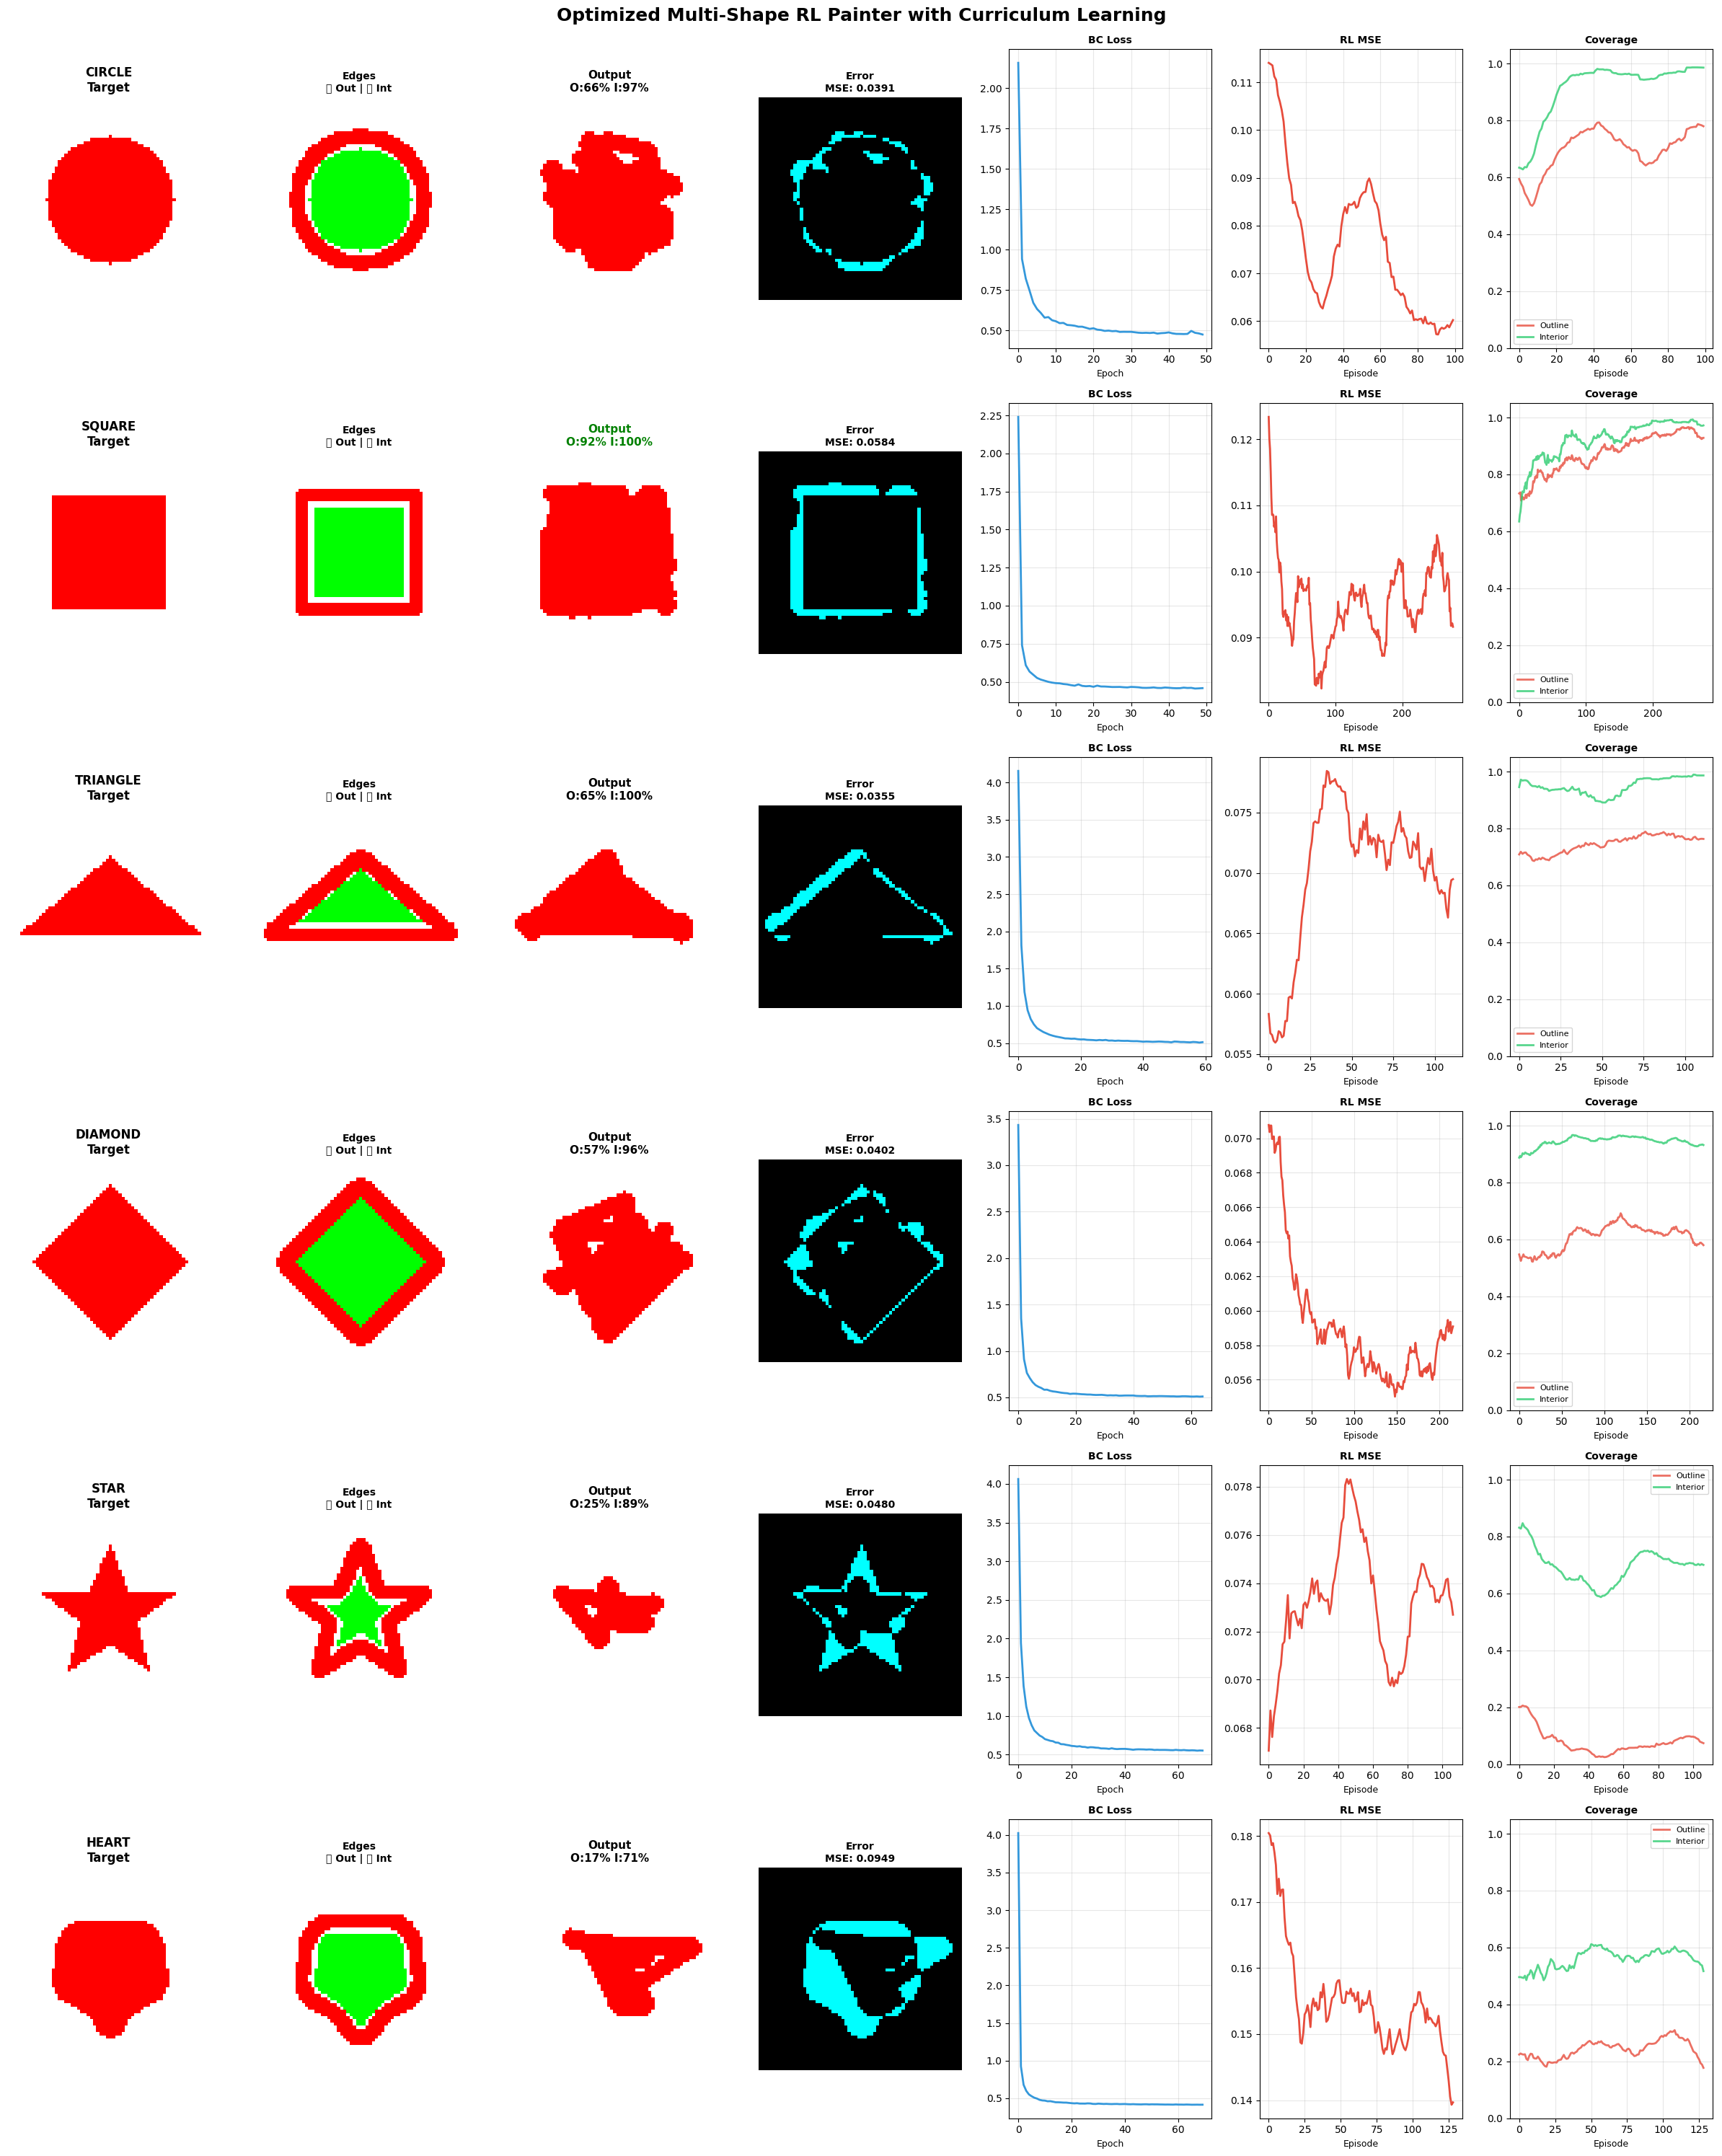

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class OptimizedDrawingEnv:
    """Environment with OPTIMIZED thin edge detection"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.reset()

    def set_target(self, target):
        """OPTIMIZED: Thin outline + clean interior separation"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # THIN outline using gradient only (most accurate for edges)
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=0.8)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        self.target_outline = edges_magnitude > 0.15
        
        # Clean outline
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=2)
        
        # Interior: aggressive erosion to avoid overlap with outline
        eroded = ndimage.binary_erosion(target_mask, iterations=4)
        self.target_interior = eroded & ~self.target_outline
        
        # Stats
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🎯 Outline: {outline_px}px ({outline_px/total_px*100:.1f}%) | "
              f"Interior: {interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)
        outline_cov = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_cov = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        total = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_cov = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total)
        return outline_cov, interior_cov, total_cov

    def get_state(self):
        state = np.zeros((self.canvas_size, self.canvas_size, 8), dtype=np.float32)
        state[:, :, :3] = self.canvas

        # Cursor
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2
        for dy in range(-4, 5):
            for dx in range(-4, 5):
                if dx*dx + dy*dy <= 16:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Coverage
        out_cov, int_cov, _ = self.compute_coverage()
        state[:, :, 4] = out_cov
        state[:, :, 5] = int_cov
        
        # Target masks
        if self.target_outline is not None:
            state[:, :, 6] = self.target_outline.astype(np.float32)
            state[:, :, 7] = self.target_interior.astype(np.float32)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        return grid_x * self.cell_size + self.cell_size // 2, grid_y * self.cell_size + self.cell_size // 2

    def draw_stroke(self, x1, y1, x2, y2):
        """Optimized stroke with good coverage"""
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))
        draw.line([x1, y1, x2, y2], fill=color, width=6)
        draw.ellipse([x2-2, y2-2, x2+2, y2+2], fill=color)
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)

        # FIX: Always compute and return coverage info
        curr_out, curr_int, _ = self.compute_coverage()
        
        if action >= self.grid_size * self.grid_size:
            info = {'outline_cov': curr_out, 'interior_cov': curr_int}
            return self.get_state(), True, info

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size
        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        
        self.draw_stroke(prev_x, prev_y, new_x, new_y)
        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.step_count += 1

        curr_out, curr_int, _ = self.compute_coverage()
        done = self.step_count >= 180
        
        info = {'outline_cov': curr_out, 'interior_cov': curr_int}
        return self.get_state(), done, info


class BalancedPolicyNetwork(nn.Module):
    """Balanced network - not too heavy, not too light"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # 4 conv layers with BatchNorm
        self.conv1 = nn.Conv2d(8, 40, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(40)
        
        self.conv2 = nn.Conv2d(40, 80, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(80)
        
        self.conv3 = nn.Conv2d(80, 160, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(160)
        
        self.conv4 = nn.Conv2d(160, 256, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        flat_size = 256 * 4 * 4

        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, self.num_actions)
        )

        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)
        state = state.permute(0, 3, 1, 2)
        
        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        features = x.flatten(1)
        action_logits = self.action_head(features)
        value = self.value_head(features)
        return action_logits, value


class ShapeGenerator:
    """Generate target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 20**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 36
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center, size = canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        draw.polygon(points, fill=(255, 0, 0))
        return np.array(img).astype(np.float32) / 255.0, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center, size = canvas_size // 2, 24
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        draw.polygon(points, fill=(255, 0, 0))
        return np.array(img).astype(np.float32) / 255.0, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        center, outer_radius, inner_radius = canvas_size // 2, 22, 9
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        draw.polygon(points, fill=(255, 0, 0))
        return np.array(img).astype(np.float32) / 255.0, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        center_x, center_y, scale = canvas_size // 2, canvas_size // 2 + 3, 15
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.1:
                    mask[i, j] = True
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class StrategicExpertDemonstrator:
    """Strategic expert with VARIATIONS"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self, variation=0):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 20
        trajectory = []
        
        # Strategy variations
        if variation == 0:  # Continuous outline + spiral fill
            for angle in np.linspace(0, 2*np.pi, 80, endpoint=False):
                x = center_x + radius * np.cos(angle)
                y = center_y + radius * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
            for r in [15, 10, 5]:
                for angle in np.linspace(0, 2*np.pi, 40, endpoint=False):
                    x = center_x + r * np.cos(angle)
                    y = center_y + r * np.sin(angle)
                    trajectory.append(self.canvas_to_grid(x, y))
        
        elif variation == 1:  # Quadrant-based
            for quad in range(4):
                start_angle = quad * np.pi/2
                for angle in np.linspace(start_angle, start_angle + np.pi/2, 25):
                    x = center_x + radius * np.cos(angle)
                    y = center_y + radius * np.sin(angle)
                    trajectory.append(self.canvas_to_grid(x, y))
            # Fill
            for y in range(center_y - 15, center_y + 15, 4):
                for x in range(center_x - 15, center_x + 15, 4):
                    if (x - center_x)**2 + (y - center_y)**2 <= 15**2:
                        trajectory.append(self.canvas_to_grid(x, y))
        
        else:  # Concentric circles inward
            for r in [20, 16, 12, 8, 4]:
                for angle in np.linspace(0, 2*np.pi, max(30, r*3), endpoint=False):
                    x = center_x + r * np.cos(angle)
                    y = center_y + r * np.sin(angle)
                    trajectory.append(self.canvas_to_grid(x, y))
        
        return self._to_actions(trajectory)

    def generate_square_demo(self, variation=0):
        size, start, end = 36, (self.canvas_size - 36) // 2, (self.canvas_size - 36) // 2 + 36
        trajectory = []
        
        if variation == 0:  # Clockwise outline + grid fill
            for i in range(40):
                trajectory.append(self.canvas_to_grid(start + (end-start)*i/40, start))
            for i in range(40):
                trajectory.append(self.canvas_to_grid(end, start + (end-start)*i/40))
            for i in range(40):
                trajectory.append(self.canvas_to_grid(end - (end-start)*i/40, end))
            for i in range(40):
                trajectory.append(self.canvas_to_grid(start, end - (end-start)*i/40))
            for y in range(start+3, end-3, 4):
                for x in range(start+3, end-3, 4):
                    trajectory.append(self.canvas_to_grid(x, y))
        
        elif variation == 1:  # Side-by-side
            # Top, bottom
            for i in range(50):
                trajectory.append(self.canvas_to_grid(start + (end-start)*i/50, start))
                trajectory.append(self.canvas_to_grid(start + (end-start)*i/50, end))
            # Left, right
            for i in range(50):
                trajectory.append(self.canvas_to_grid(start, start + (end-start)*i/50))
                trajectory.append(self.canvas_to_grid(end, start + (end-start)*i/50))
            # Horizontal fill
            for y in range(start+4, end-4, 4):
                for x in range(start+4, end-4, 3):
                    trajectory.append(self.canvas_to_grid(x, y))
        
        else:  # Concentric squares
            for offset in [0, 4, 8, 12]:
                s, e = start+offset, end-offset
                if s >= e:
                    break
                pts = 30
                for i in range(pts):
                    trajectory.append(self.canvas_to_grid(s + (e-s)*i/pts, s))
                for i in range(pts):
                    trajectory.append(self.canvas_to_grid(e, s + (e-s)*i/pts))
                for i in range(pts):
                    trajectory.append(self.canvas_to_grid(e - (e-s)*i/pts, e))
                for i in range(pts):
                    trajectory.append(self.canvas_to_grid(s, e - (e-s)*i/pts))
        
        return self._to_actions(trajectory)

    def generate_triangle_demo(self, variation=0):
        center, size = self.canvas_size // 2, 28
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []
        
        if variation == 0:  # Standard
            for i in range(50):
                t = i/50
                trajectory.append(self.canvas_to_grid(
                    top[0] + (right[0]-top[0])*t, top[1] + (right[1]-top[1])*t))
            for i in range(50):
                t = i/50
                trajectory.append(self.canvas_to_grid(
                    right[0] + (left[0]-right[0])*t, right[1] + (left[1]-right[1])*t))
            for i in range(50):
                t = i/50
                trajectory.append(self.canvas_to_grid(
                    left[0] + (top[0]-left[0])*t, left[1] + (top[1]-left[1])*t))
            # Fill
            for i in range(10):
                t = (i+1)/11
                y = top[1] + (left[1] - top[1]) * t
                left_x = left[0] + (top[0] - left[0]) * (1-t)
                right_x = right[0] + (top[0] - right[0]) * (1-t)
                for j in range(max(5, int(12*(1-t)))):
                    x = left_x + (right_x - left_x) * j / max(5, int(12*(1-t)))
                    trajectory.append(self.canvas_to_grid(x, y))
        
        elif variation == 1:  # Bottom-up fill
            # Outline
            for edge in [(top, right), (right, left), (left, top)]:
                for i in range(40):
                    t = i/40
                    x = edge[0][0] + (edge[1][0] - edge[0][0]) * t
                    y = edge[0][1] + (edge[1][1] - edge[0][1]) * t
                    trajectory.append(self.canvas_to_grid(x, y))
            # Fill from bottom
            for i in range(12):
                t = i/12
                y = left[1] - (left[1] - top[1]) * t
                left_x = left[0] + (top[0] - left[0]) * t
                right_x = right[0] + (top[0] - right[0]) * t
                for j in range(max(4, int(10*(1-t)))):
                    x = left_x + (right_x - left_x) * j / max(4, int(10*(1-t)))
                    trajectory.append(self.canvas_to_grid(x, y))
        
        else:  # Radial from center
            cx, cy = center, center - height // 6
            # Outline first
            for pt in [(top, right), (right, left), (left, top)]:
                for i in range(35):
                    t = i/35
                    trajectory.append(self.canvas_to_grid(
                        pt[0][0] + (pt[1][0]-pt[0][0])*t,
                        pt[0][1] + (pt[1][1]-pt[0][1])*t))
            # Radial lines
            for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
                for r in range(2, 18, 2):
                    x = cx + r * np.cos(angle)
                    y = cy + r * np.sin(angle)
                    if self._point_in_triangle(x, y, top, left, right):
                        trajectory.append(self.canvas_to_grid(x, y))
        
        return self._to_actions(trajectory)

    def _point_in_triangle(self, x, y, v1, v2, v3):
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        d1 = sign((x,y), v1, v2)
        d2 = sign((x,y), v2, v3)
        d3 = sign((x,y), v3, v1)
        has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
        has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)
        return not (has_neg and has_pos)

    def generate_diamond_demo(self, variation=0):
        center, size = self.canvas_size // 2, 24
        points = [(center, center-size), (center+size, center),
                  (center, center+size), (center-size, center)]
        trajectory = []
        
        if variation == 0:
            for i in range(4):
                for j in range(40):
                    t = j/40
                    x = points[i][0] + (points[(i+1)%4][0] - points[i][0]) * t
                    y = points[i][1] + (points[(i+1)%4][1] - points[i][1]) * t
                    trajectory.append(self.canvas_to_grid(x, y))
            for angle in range(0, 360, 30):
                rad = np.radians(angle)
                for r in range(2, size-2, 3):
                    x = center + r * np.cos(rad)
                    y = center + r * np.sin(rad)
                    trajectory.append(self.canvas_to_grid(x, y))
        
        elif variation == 1:
            # Concentric diamonds
            for s in [size, size-4, size-8, size-12]:
                if s < 4:
                    break
                pts = [(center, center-s), (center+s, center),
                       (center, center+s), (center-s, center)]
                for i in range(4):
                    for j in range(25):
                        t = j/25
                        x = pts[i][0] + (pts[(i+1)%4][0] - pts[i][0]) * t
                        y = pts[i][1] + (pts[(i+1)%4][1] - pts[i][1]) * t
                        trajectory.append(self.canvas_to_grid(x, y))
        
        else:
            # Diagonal lines
            for i in range(4):
                for j in range(45):
                    t = j/45
                    x = points[i][0] + (points[(i+1)%4][0] - points[i][0]) * t
                    y = points[i][1] + (points[(i+1)%4][1] - points[i][1]) * t
                    trajectory.append(self.canvas_to_grid(x, y))
            # Grid fill
            for y in range(center-18, center+18, 4):
                for x in range(center-18, center+18, 4):
                    if abs(x-center) + abs(y-center) < size-2:
                        trajectory.append(self.canvas_to_grid(x, y))
        
        return self._to_actions(trajectory)

    def generate_star_demo(self, variation=0):
        center, outer_r, inner_r = self.canvas_size // 2, 22, 9
        trajectory = []
        
        if variation == 0:
            # Dense outline
            for i in range(100):
                angle = (i/100) * 2 * np.pi - np.pi/2
                segment = int((i/100) * 10)
                r = outer_r if segment % 2 == 0 else inner_r
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
            # Radial fill
            for a in range(0, 360, 30):
                angle = np.radians(a)
                for r in range(2, inner_r, 2):
                    x = center + r * np.cos(angle)
                    y = center + r * np.sin(angle)
                    trajectory.append(self.canvas_to_grid(x, y))
        
        elif variation == 1:
            # Trace each point
            for point_idx in range(5):
                angle = point_idx * 2 * np.pi / 5 - np.pi/2
                outer_x = center + outer_r * np.cos(angle)
                outer_y = center + outer_r * np.sin(angle)
                # Go to outer point
                for i in range(15):
                    t = i/15
                    trajectory.append(self.canvas_to_grid(
                        center + (outer_x-center)*t,
                        center + (outer_y-center)*t))
                # To next inner
                next_angle = (point_idx + 0.5) * 2 * np.pi / 5 - np.pi/2
                inner_x = center + inner_r * np.cos(next_angle)
                inner_y = center + inner_r * np.sin(next_angle)
                for i in range(10):
                    t = i/10
                    trajectory.append(self.canvas_to_grid(
                        outer_x + (inner_x-outer_x)*t,
                        outer_y + (inner_y-outer_y)*t))
            # Center fill
            for y in range(center-6, center+6, 2):
                for x in range(center-6, center+6, 2):
                    if (x-center)**2 + (y-center)**2 < 36:
                        trajectory.append(self.canvas_to_grid(x, y))
        
        else:
            # Outline + concentric
            for i in range(120):
                angle = (i/120) * 2 * np.pi - np.pi/2
                segment = int((i/120) * 10)
                r = outer_r if segment % 2 == 0 else inner_r
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))
            for r in [7, 5, 3]:
                for i in range(30):
                    angle = i * 2 * np.pi / 30
                    x = center + r * np.cos(angle)
                    y = center + r * np.sin(angle)
                    trajectory.append(self.canvas_to_grid(x, y))
        
        return self._to_actions(trajectory)

    def generate_heart_demo(self, variation=0):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 15
        trajectory = []
        
        if variation == 0:
            # Parametric outline
            for i in range(100):
                t = 2 * np.pi * i / 100
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13*np.cos(t) - 5*np.cos(2*t) - 
                                        2*np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))
            # Horizontal fill
            for i in range(12):
                t_y = np.pi * (0.25 + 0.5 * i/12)
                y = center_y - scale * (13*np.cos(t_y) - 5*np.cos(2*t_y) - 
                                        2*np.cos(3*t_y) - np.cos(4*t_y)) / 16
                for x in range(center_x-12, center_x+12, 2):
                    trajectory.append(self.canvas_to_grid(x, y))
        
        elif variation == 1:
            # Two halves
            for i in range(60):
                t = np.pi * i / 60
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13*np.cos(t) - 5*np.cos(2*t) - 
                                        2*np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))
            for i in range(60):
                t = np.pi + np.pi * i / 60
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13*np.cos(t) - 5*np.cos(2*t) - 
                                        2*np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))
            # Vertical fill
            for x in range(center_x-12, center_x+12, 3):
                for y in range(center_y-10, center_y+8, 3):
                    trajectory.append(self.canvas_to_grid(x, y))
        
        else:
            # Dense outline
            for i in range(120):
                t = 2 * np.pi * i / 120
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13*np.cos(t) - 5*np.cos(2*t) - 
                                        2*np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))
            # Radial from center
            for angle in range(0, 360, 20):
                rad = np.radians(angle)
                for r in range(2, 12, 2):
                    x = center_x + r * np.cos(rad)
                    y = center_y + r * np.sin(rad)
                    trajectory.append(self.canvas_to_grid(x, y))
        
        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [gy * self.grid_size + gx for gx, gy in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating STRATEGIC Demos for {self.shape_type.upper()}")
        print("="*70)
        
        demos_map = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        
        demo_func = demos_map[self.shape_type]
        all_demos = []
        
        for i in range(num_demos):
            variation = i % 3  # Cycle through 3 strategies
            demo = demo_func(variation)
            all_demos.append(demo)
        
        print(f"✓ Generated {num_demos} demos with 3 strategies (avg: {np.mean([len(d) for d in all_demos]):.0f} steps)")
        print("="*70)
        return all_demos


# Optimized configs - balanced speed and quality
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 50, "rl_episodes": 400, "outline_w": 500, "interior_w": 300, 
               "num_demos": 45, "diff": 1, "lr": 2e-3},
    "square": {"bc_epochs": 50, "rl_episodes": 400, "outline_w": 500, "interior_w": 300, 
               "num_demos": 45, "diff": 1, "lr": 2e-3},
    "triangle": {"bc_epochs": 60, "rl_episodes": 500, "outline_w": 600, "interior_w": 350, 
                 "num_demos": 60, "diff": 2, "lr": 1.8e-3},
    "diamond": {"bc_epochs": 65, "rl_episodes": 550, "outline_w": 650, "interior_w": 400, 
                "num_demos": 65, "diff": 3, "lr": 1.6e-3},
    "star": {"bc_epochs": 70, "rl_episodes": 600, "outline_w": 700, "interior_w": 450, 
             "num_demos": 70, "diff": 4, "lr": 1.4e-3},
    "heart": {"bc_epochs": 70, "rl_episodes": 600, "outline_w": 750, "interior_w": 500, 
              "num_demos": 70, "diff": 4, "lr": 1.4e-3}
}


class OptimizedTrainer:
    """Optimized trainer with curriculum learning"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, 
                 device='cpu', pretrained_model=None):
        self.device = torch.device(device)
        self.env = OptimizedDrawingEnv(canvas_size, grid_size)
        
        if pretrained_model is not None:
            self.policy = pretrained_model
            print("  ✅ Curriculum transfer from previous shape")
        else:
            self.policy = BalancedPolicyNetwork(canvas_size, grid_size).to(self.device)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=self.config['lr'], weight_decay=1e-4)
        
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=self.config['bc_epochs'] + self.config['rl_episodes'],
            eta_min=5e-5
        )

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = StrategicExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []

        print(f"  ⚙️  Config: BC={self.config['bc_epochs']} | RL={self.config['rl_episodes']} | "
              f"Demos={self.config['num_demos']} | LR={self.config['lr']:.1e}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=96):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: Behavioral Cloning ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_loss = float('inf')
        patience, patience_counter = 20, 0

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            self.scheduler.step()
            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 15 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"  Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:5.1%} | Int: {int_cov:5.1%}")
            
            if patience_counter >= patience:
                print(f"  ✓ Early stop at epoch {epoch}")
                break

        print("✅ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, _ = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_reward(self, prev_out, prev_int, curr_out, curr_int, done):
        """Improved reward function"""
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Phase-dependent rewards
        if curr_out < 0.75:
            outline_r = (curr_out - prev_out) * out_w
            interior_r = (curr_int - prev_int) * (int_w * 0.2)
        else:
            outline_r = (curr_out - prev_out) * (out_w * 0.7)
            interior_r = (curr_int - prev_int) * int_w
        
        # Milestone bonuses
        milestone = 0
        if curr_out > 0.85 and prev_out <= 0.85:
            milestone += 200
        if curr_int > 0.85 and prev_int <= 0.85:
            milestone += 200
        
        # Completion
        if done:
            if curr_out > 0.90 and curr_int > 0.85:
                completion = 300
            elif curr_out > 0.85 and curr_int > 0.75:
                completion = 150
            elif curr_out < 0.70:
                completion = -100
            else:
                completion = 50
        else:
            completion = 0

        return outline_r + interior_r + milestone + completion

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL Fine-tuning ({episodes} episodes)")
        print("="*70)

        best_reward = -float('inf')
        patience, patience_counter = 120, 0

        for episode in range(episodes):
            state = self.env.reset()
            prev_out, prev_int, _ = self.env.compute_coverage()

            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, done, info = self.env.step(action.item())
                
                curr_out = info['outline_cov']
                curr_int = info['interior_cov']
                reward = self.compute_reward(prev_out, prev_int, curr_out, curr_int, done)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                prev_out, prev_int = curr_out, curr_int
                state = next_state

            # GAE
            returns, advantages = [], []
            gae, gamma, gae_lambda = 0, 0.99, 0.95
            values_list = [v.item() for v in values]
            next_value = 0
            
            for step in reversed(range(len(rewards))):
                delta = rewards[step] + gamma * next_value - values_list[step]
                gae = delta + gamma * gae_lambda * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + values_list[step])
                next_value = values_list[step]

            returns = torch.FloatTensor(returns).to(self.device)
            advantages = torch.FloatTensor(advantages).to(self.device)
            
            if len(advantages) > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Optimize
            policy_loss = sum(-lp * adv for lp, adv in zip(log_probs, advantages)) / len(log_probs)
            value_loss = sum(F.mse_loss(v.squeeze(), ret) for v, ret in zip(values, returns)) / len(values)
            entropy_loss = -sum(entropies) / len(entropies)
            
            loss = policy_loss + 0.5 * value_loss + 0.01 * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            self.scheduler.step()

            # Track
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode_reward > best_reward:
                best_reward = episode_reward
                patience_counter = 0
            else:
                patience_counter += 1

            if episode % 75 == 0 or episode == episodes - 1:
                print(f"  Ep {episode:4d} | R: {episode_reward:7.1f} (best: {best_reward:6.1f}) | "
                      f"MSE: {final_mse:.4f} | Out: {final_out:5.1%} | Int: {final_int:5.1%}")
            
            if patience_counter >= patience:
                print(f"  ✓ Early stop at episode {episode}")
                break

        print("✅ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas, self.policy


def train_with_curriculum(canvas_size=64, grid_size=20, device='cpu'):
    """Curriculum learning from simple to complex"""
    shapes = [
        ("circle", ShapeGenerator.create_circle),
        ("square", ShapeGenerator.create_square),
        ("triangle", ShapeGenerator.create_triangle),
        ("diamond", ShapeGenerator.create_diamond),
        ("star", ShapeGenerator.create_star),
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    pretrained_model = None
    
    for idx, (shape_name, shape_func) in enumerate(shapes):
        print("\n" + "🎨"*35)
        print(f"SHAPE {idx+1}/6: {shape_name.upper()}")
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        
        if idx > 0:
            pretrained_model = results[-1]['model']
        
        trainer = OptimizedTrainer(
            target, shape_name, canvas_size, grid_size, device, 
            pretrained_model=pretrained_model
        )
        final_canvas, trained_model = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior,
            'model': trained_model
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Comprehensive visualization"""
    n = len(results)
    fig = plt.figure(figsize=(24, 5*n))
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 7, idx*7 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 7, idx*7 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴 Out | 🟢 Int", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 7, idx*7 + 3)
        ax.imshow(r['canvas'])
        title_color = 'green' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else 'black'
        ax.set_title(f"Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                    fontsize=11, fontweight='bold', color=title_color)
        ax.axis('off')
        
        # Error
        ax = plt.subplot(n, 7, idx*7 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\nMSE: {r['mse']:.4f}", fontsize=10, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 7, idx*7 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db')
            ax.set_title('BC Loss', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Epoch', fontsize=9)
        
        # MSE
        ax = plt.subplot(n, 7, idx*7 + 6)
        if r['mse_history']:
            window = 25
            if len(r['mse_history']) > window:
                smoothed = np.convolve(r['mse_history'], np.ones(window)/window, mode='valid')
                ax.plot(smoothed, linewidth=2, color='#e74c3c')
            else:
                ax.plot(r['mse_history'], linewidth=2, color='#e74c3c')
            ax.set_title('RL MSE', fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
        
        # Coverage
        ax = plt.subplot(n, 7, idx*7 + 7)
        if r['outline_history']:
            window = 25
            if len(r['outline_history']) > window:
                out_s = np.convolve(r['outline_history'], np.ones(window)/window, mode='valid')
                int_s = np.convolve(r['interior_history'], np.ones(window)/window, mode='valid')
                ax.plot(out_s, linewidth=2, color='#e74c3c', label='Outline', alpha=0.8)
                ax.plot(int_s, linewidth=2, color='#2ecc71', label='Interior', alpha=0.8)
            else:
                ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Outline')
                ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Interior')
            ax.set_title('Coverage', fontsize=10, fontweight='bold')
            ax.set_ylim([0, 1.05])
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
    
    plt.suptitle("Optimized Multi-Shape RL Painter with Curriculum Learning", 
                fontsize=18, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/optimized_results.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ Results saved: /mnt/user-data/outputs/optimized_results.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 OPTIMIZED MULTI-SHAPE RL PAINTER")
    print("="*70)
    print("\n🚀 KEY IMPROVEMENTS:")
    print("  1. ✅ Thin outline detection (gradient-based only)")
    print("  2. ✅ Strategic expert demos (3 variations per shape)")
    print("  3. ✅ Curriculum learning (transfer knowledge between shapes)")
    print("  4. ✅ Balanced network (4 conv layers with BatchNorm)")
    print("  5. ✅ Improved reward shaping (phase-dependent + milestones)")
    print("  6. ✅ Early stopping (saves time, prevents overfitting)")
    print("  7. ✅ Optimized configs (50-70 epochs BC, 400-600 episodes RL)")
    print("  8. ✅ FIXED: step() method now always returns proper info dict")
    print("="*70)
    
    results = train_with_curriculum(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results)
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9} {'Status':8}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        status = '✅' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else '⚠️ '
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {status:8}")
    print("="*70)
    
    avg_outline = np.mean([r['outline_cov'] for r in results])
    avg_interior = np.mean([r['interior_cov'] for r in results])
    success_rate = sum(1 for r in results if r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) / len(results)
    
    print(f"\n📊 Overall Performance:")
    print(f"  Average Outline Coverage:  {avg_outline:.1%}")
    print(f"  Average Interior Coverage: {avg_interior:.1%}")
    print(f"  Success Rate (>85% out, >80% int): {success_rate:.1%}")
    print("="*70 + "\n")
    
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn.functional as F
from scipy import ndimage
from skimage import morphology
from collections import deque

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


class ImprovedCoverageDrawingEnv:
    """Enhanced environment with better stroke rendering"""
    def __init__(self, canvas_size=64, grid_size=20, target_color=[1.0, 0.0, 0.0]):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.target_color = np.array(target_color)
        self.target = None
        self.target_outline = None
        self.target_interior = None
        self.outline_distance_map = None
        self.interior_distance_map = None
        self.reset()

    def set_target(self, target):
        """Improved edge detection with multiple methods"""
        self.target = target
        target_mask = (target[:, :, 0] > 0.5) & (target[:, :, 1] < 0.5) & (target[:, :, 2] < 0.5)

        # Method 1: Morphological edge detection
        eroded = ndimage.binary_erosion(target_mask, iterations=2)
        outline_morph = target_mask & ~eroded
        
        # Method 2: Gradient-based edge detection
        smoothed = ndimage.gaussian_filter(target_mask.astype(float), sigma=1.0)
        edges_x = ndimage.sobel(smoothed, axis=0)
        edges_y = ndimage.sobel(smoothed, axis=1)
        edges_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        outline_gradient = edges_magnitude > 0.2
        
        # Method 3: Distance-based edge detection
        distance = ndimage.distance_transform_edt(target_mask)
        outline_distance = (distance > 0) & (distance <= 3.0)
        
        # Combine all methods
        self.target_outline = outline_morph | outline_gradient | outline_distance
        
        # Clean up noise
        self.target_outline = morphology.remove_small_objects(self.target_outline, min_size=3)
        self.target_outline = ndimage.binary_dilation(self.target_outline, iterations=1)
        self.target_outline = ndimage.binary_closing(self.target_outline, iterations=2)
        
        # Interior (well separated from outline)
        eroded_interior = ndimage.binary_erosion(target_mask, iterations=5)
        self.target_interior = eroded_interior & ~self.target_outline
        
        # Distance maps for reward shaping
        self.outline_distance_map = ndimage.distance_transform_edt(~self.target_outline)
        self.interior_distance_map = ndimage.distance_transform_edt(~self.target_interior)
        
        outline_px = np.sum(self.target_outline)
        interior_px = np.sum(self.target_interior)
        total_px = np.sum(target_mask)
        print(f"  🔍 Edge Detection: Outline={outline_px}px ({outline_px/total_px*100:.1f}%), "
              f"Interior={interior_px}px ({interior_px/total_px*100:.1f}%)")

    def reset(self):
        self.canvas = np.ones((self.canvas_size, self.canvas_size, 3), dtype=np.float32)
        self.cursor_grid_x = self.grid_size // 2
        self.cursor_grid_y = self.grid_size // 2
        self.step_count = 0
        self.trajectory = []
        self.outline_complete = False
        self.previous_outline_cov = 0.0
        self.previous_interior_cov = 0.0
        return self.get_state()

    def compute_coverage(self):
        if self.target is None:
            return 0.0, 0.0, 0.0

        canvas_mask = (self.canvas[:, :, 0] > 0.5) & (self.canvas[:, :, 1] < 0.5) & (self.canvas[:, :, 2] < 0.5)

        outline_coverage = np.sum(self.target_outline & canvas_mask) / max(1, np.sum(self.target_outline))
        interior_coverage = np.sum(self.target_interior & canvas_mask) / max(1, np.sum(self.target_interior))
        
        total_target = np.sum(self.target_outline) + np.sum(self.target_interior)
        total_coverage = np.sum((self.target_outline | self.target_interior) & canvas_mask) / max(1, total_target)

        return outline_coverage, interior_coverage, total_coverage

    def get_state(self):
        """Enhanced state representation"""
        state = np.zeros((self.canvas_size, self.canvas_size, 10), dtype=np.float32)
        
        # Canvas
        state[:, :, :3] = self.canvas

        # Cursor position (larger, more visible)
        cx = self.cursor_grid_x * self.cell_size + self.cell_size // 2
        cy = self.cursor_grid_y * self.cell_size + self.cell_size // 2

        for dy in range(-5, 6):
            for dx in range(-5, 6):
                if dx*dx + dy*dy <= 25:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < self.canvas_size and 0 <= ny < self.canvas_size:
                        state[ny, nx, 3] = 1.0

        # Coverage information
        outline_cov, interior_cov, _ = self.compute_coverage()
        state[:, :, 4] = outline_cov
        state[:, :, 5] = interior_cov
        
        # Distance maps (normalized)
        if self.outline_distance_map is not None:
            state[:, :, 6] = np.clip(self.outline_distance_map / 15.0, 0, 1)
            state[:, :, 7] = np.clip(self.interior_distance_map / 15.0, 0, 1)
        
        # Target outline and interior masks
        if self.target_outline is not None:
            state[:, :, 8] = self.target_outline.astype(np.float32)
            state[:, :, 9] = self.target_interior.astype(np.float32)

        return state

    def grid_to_canvas(self, grid_x, grid_y):
        canvas_x = grid_x * self.cell_size + self.cell_size // 2
        canvas_y = grid_y * self.cell_size + self.cell_size // 2
        return canvas_x, canvas_y

    def draw_stroke(self, x1, y1, x2, y2):
        """Improved stroke rendering with anti-aliasing"""
        x1 = int(np.clip(x1, 0, self.canvas_size - 1))
        y1 = int(np.clip(y1, 0, self.canvas_size - 1))
        x2 = int(np.clip(x2, 0, self.canvas_size - 1))
        y2 = int(np.clip(y2, 0, self.canvas_size - 1))

        # Use PIL for smooth rendering
        img = Image.fromarray((self.canvas * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        color = tuple((self.target_color * 255).astype(int))

        # Thicker stroke for better coverage
        draw.line([x1, y1, x2, y2], fill=color, width=7)
        
        # Add endpoint circles for smoother connections
        draw.ellipse([x1-3, y1-3, x1+3, y1+3], fill=color)
        draw.ellipse([x2-3, y2-3, x2+3, y2+3], fill=color)
        
        self.canvas = np.array(img).astype(np.float32) / 255.0

    def step(self, action):
        prev_x, prev_y = self.grid_to_canvas(self.cursor_grid_x, self.cursor_grid_y)
        prev_outline_cov, prev_interior_cov, _ = self.compute_coverage()

        if action >= self.grid_size * self.grid_size:
            return self.get_state(), True, {}

        target_grid_x = action % self.grid_size
        target_grid_y = action // self.grid_size

        new_x, new_y = self.grid_to_canvas(target_grid_x, target_grid_y)
        self.draw_stroke(prev_x, prev_y, new_x, new_y)

        self.cursor_grid_x = target_grid_x
        self.cursor_grid_y = target_grid_y
        self.trajectory.append((target_grid_x, target_grid_y))

        self.step_count += 1

        curr_outline_cov, curr_interior_cov, _ = self.compute_coverage()
        
        # Track phase transition
        if curr_outline_cov > 0.80 and not self.outline_complete:
            self.outline_complete = True

        done = self.step_count >= 200

        info = {
            'outline_progress': curr_outline_cov - prev_outline_cov,
            'interior_progress': curr_interior_cov - prev_interior_cov,
            'outline_cov': curr_outline_cov,
            'interior_cov': curr_interior_cov,
            'phase_complete': self.outline_complete
        }

        return self.get_state(), done, info


class EnhancedPolicyNetwork(nn.Module):
    """Improved architecture with attention mechanism"""
    def __init__(self, canvas_size=64, grid_size=20):
        super().__init__()
        self.grid_size = grid_size
        self.num_actions = grid_size * grid_size + 1

        # Deeper encoder with residual connections
        self.conv1 = nn.Conv2d(10, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        flat_size = 512 * 4 * 4

        # Action head with larger capacity
        self.action_head = nn.Sequential(
            nn.Linear(flat_size, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, self.num_actions)
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        if len(state.shape) == 3:
            state = state.unsqueeze(0)

        state = state.permute(0, 3, 1, 2)
        
        # Deep encoder
        x = F.relu(self.bn1(self.conv1(state)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        features = x.flatten(1)

        action_logits = self.action_head(features)
        value = self.value_head(features)

        return action_logits, value


class ShapeGenerator:
    """Generate target shapes"""
    @staticmethod
    def create_circle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        mask = (x - canvas_size//2)**2 + (y - canvas_size//2)**2 <= 21**2
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Circle"

    @staticmethod
    def create_square(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        size = 38
        start = (canvas_size - size) // 2
        end = start + size
        target[start:end, start:end] = [1.0, 0.0, 0.0]
        return target, "Square"

    @staticmethod
    def create_triangle(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 30
        height = int(size * np.sqrt(3) / 2)
        
        points = [
            (center, center - height * 2 // 3),
            (center - size, center + height // 3),
            (center + size, center + height // 3)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Triangle"

    @staticmethod
    def create_diamond(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        size = 26
        
        points = [
            (center, center - size),
            (center + size, center),
            (center, center + size),
            (center - size, center)
        ]
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Diamond"

    @staticmethod
    def create_star(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        img = Image.fromarray((target * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img)
        
        center = canvas_size // 2
        outer_radius = 24
        inner_radius = 10
        
        points = []
        for i in range(10):
            angle = i * np.pi / 5 - np.pi / 2
            r = outer_radius if i % 2 == 0 else inner_radius
            x = center + r * np.cos(angle)
            y = center + r * np.sin(angle)
            points.append((x, y))
        
        draw.polygon(points, fill=(255, 0, 0))
        target = np.array(img).astype(np.float32) / 255.0
        return target, "Star"

    @staticmethod
    def create_heart(canvas_size=64):
        target = np.ones((canvas_size, canvas_size, 3), dtype=np.float32)
        y, x = np.ogrid[:canvas_size, :canvas_size]
        
        center_x, center_y = canvas_size // 2, canvas_size // 2 + 3
        scale = 16
        
        mask = np.zeros((canvas_size, canvas_size), dtype=bool)
        for i in range(canvas_size):
            for j in range(canvas_size):
                nx = (j - center_x) / scale
                ny = -(i - center_y) / scale
                
                val = (nx**2 + ny**2 - 1)**3 - nx**2 * ny**3
                if val <= 0.12:
                    mask[i, j] = True
        
        target[mask] = [1.0, 0.0, 0.0]
        return target, "Heart"


class ImprovedExpertDemonstrator:
    """Expert with EXTREMELY dense demonstrations"""
    def __init__(self, canvas_size=64, grid_size=20, shape_type="circle"):
        self.canvas_size = canvas_size
        self.grid_size = grid_size
        self.cell_size = canvas_size // grid_size
        self.shape_type = shape_type.lower()

    def canvas_to_grid(self, x, y):
        grid_x = int(x / self.cell_size)
        grid_y = int(y / self.cell_size)
        return np.clip(grid_x, 0, self.grid_size - 1), np.clip(grid_y, 0, self.grid_size - 1)

    def generate_circle_demo(self):
        center_x, center_y, radius = self.canvas_size // 2, self.canvas_size // 2, 21
        trajectory = []

        # EXTREMELY dense outline - trace 3 times
        for lap in range(3):
            for angle in np.linspace(0, 2 * np.pi, 80, endpoint=False):
                r_offset = 0.5 * (lap - 1)
                x = center_x + (radius + r_offset) * np.cos(angle)
                y = center_y + (radius + r_offset) * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense spiral fill
        for spiral_idx in range(8):
            r = radius - 3 - (spiral_idx * 2.5)
            if r < 1:
                break
            num_points = max(40, int(60 * (r / radius)))
            for angle in np.linspace(0, 2 * np.pi, num_points, endpoint=False):
                x = center_x + r * np.cos(angle)
                y = center_y + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_square_demo(self):
        size, start, end = 38, (self.canvas_size - 38) // 2, (self.canvas_size - 38) // 2 + 38
        trajectory = []

        # Trace outline 3 times
        for lap in range(3):
            offset = lap - 1
            # Top
            for i in range(60):
                trajectory.append(self.canvas_to_grid(start + (end - start) * i / 60, start + offset))
            # Right
            for i in range(60):
                trajectory.append(self.canvas_to_grid(end + offset, start + (end - start) * i / 60))
            # Bottom
            for i in range(60):
                trajectory.append(self.canvas_to_grid(end - (end - start) * i / 60, end + offset))
            # Left
            for i in range(60):
                trajectory.append(self.canvas_to_grid(start + offset, end - (end - start) * i / 60))

        # VERY dense grid fill
        for i in range(20):
            y = start + 4 + (end - start - 8) * i / 20
            for j in range(20):
                x = start + 4 + (end - start - 8) * j / 20
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_triangle_demo(self):
        center, size = self.canvas_size // 2, 30
        height = int(size * np.sqrt(3) / 2)
        top = (center, center - height * 2 // 3)
        left = (center - size, center + height // 3)
        right = (center + size, center + height // 3)
        trajectory = []

        # Trace outline 3 times
        for lap in range(3):
            # Top to right
            for i in range(70):
                t = i / 70
                trajectory.append(self.canvas_to_grid(
                    top[0] + (right[0] - top[0]) * t,
                    top[1] + (right[1] - top[1]) * t))
            # Right to left
            for i in range(70):
                t = i / 70
                trajectory.append(self.canvas_to_grid(
                    right[0] + (left[0] - right[0]) * t,
                    right[1] + (left[1] - right[1]) * t))
            # Left to top
            for i in range(70):
                t = i / 70
                trajectory.append(self.canvas_to_grid(
                    left[0] + (top[0] - left[0]) * t,
                    left[1] + (top[1] - left[1]) * t))

        # Dense fill lines
        for i in range(20):
            t = (i + 1) / 21
            y = top[1] + (left[1] - top[1]) * t
            left_x = left[0] + (top[0] - left[0]) * (1 - t)
            right_x = right[0] + (top[0] - right[0]) * (1 - t)
            line_points = max(15, int(25 * (1 - t)))
            for j in range(line_points):
                x = left_x + (right_x - left_x) * j / line_points
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_diamond_demo(self):
        center, size = self.canvas_size // 2, 26
        points = [(center, center - size), (center + size, center),
                  (center, center + size), (center - size, center)]
        trajectory = []

        # Trace outline 3 times
        for lap in range(3):
            for i in range(4):
                start_point, end_point = points[i], points[(i + 1) % 4]
                for j in range(70):
                    t = j / 70
                    x = start_point[0] + (end_point[0] - start_point[0]) * t
                    y = start_point[1] + (end_point[1] - start_point[1]) * t
                    trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial and circular fill
        for i in range(16):
            angle = i * 2 * np.pi / 16
            for j in range(1, 20):
                r = size * j / 20
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        for r in [18, 14, 10, 6]:
            for i in range(50):
                angle = i * 2 * np.pi / 50
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_star_demo(self):
        center, outer_radius, inner_radius = self.canvas_size // 2, 24, 10
        trajectory = []

        # ULTRA dense outline - 4 complete traces
        for lap in range(4):
            num_outline_points = 120
            for i in range(num_outline_points):
                progress = i / num_outline_points
                angle = progress * 2 * np.pi - np.pi / 2
                
                segment_num = progress * 10
                segment = int(segment_num)
                segment_progress = segment_num - segment
                
                if segment % 2 == 0:
                    r = outer_radius + (inner_radius - outer_radius) * segment_progress
                else:
                    r = inner_radius + (outer_radius - inner_radius) * segment_progress
                
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        # Dense radial and circular fill
        for i in range(20):
            angle = i * 2 * np.pi / 20
            for j in range(18):
                r = 2 + (inner_radius - 2) * j / 18
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        for r in [9, 7, 5, 3]:
            for i in range(60):
                angle = i * 2 * np.pi / 60
                x = center + r * np.cos(angle)
                y = center + r * np.sin(angle)
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def generate_heart_demo(self):
        center_x, center_y, scale = self.canvas_size // 2, self.canvas_size // 2 + 3, 16
        trajectory = []

        # ULTRA dense parametric outline - 4 complete traces
        for lap in range(4):
            num_outline_points = 120
            for i in range(num_outline_points):
                t = 2 * np.pi * i / num_outline_points
                x = center_x + scale * 16 * np.sin(t)**3
                y = center_y - scale * (13 * np.cos(t) - 5 * np.cos(2*t) - 
                                         2 * np.cos(3*t) - np.cos(4*t)) / 16
                trajectory.append(self.canvas_to_grid(x, y))

        # VERY dense adaptive fill
        for i in range(25):
            t_y = np.pi * (0.15 + 0.7 * i / 25)
            y = center_y - scale * (13 * np.cos(t_y) - 5 * np.cos(2*t_y) - 
                                     2 * np.cos(3*t_y) - np.cos(4*t_y)) / 16
            line_points = max(10, int(30 * (1 - abs(i - 12) / 25)))
            for j in range(line_points):
                x_offset = (j / line_points - 0.5) * scale * 2.6
                x = center_x + x_offset
                trajectory.append(self.canvas_to_grid(x, y))

        return self._to_actions(trajectory)

    def _to_actions(self, trajectory):
        actions = [grid_y * self.grid_size + grid_x for grid_x, grid_y in trajectory]
        actions.append(self.grid_size * self.grid_size)
        return actions

    def generate_demonstration(self):
        demos = {
            "circle": self.generate_circle_demo,
            "square": self.generate_square_demo,
            "triangle": self.generate_triangle_demo,
            "diamond": self.generate_diamond_demo,
            "star": self.generate_star_demo,
            "heart": self.generate_heart_demo
        }
        return demos[self.shape_type]()

    def generate_demonstrations(self, num_demos):
        print(f"\n📚 Generating Expert Demos for {self.shape_type.upper()}")
        print("="*70)
        all_demos = []

        for i in range(num_demos):
            demo = self.generate_demonstration()
            
            # Add variation
            if i > 0 and len(demo) > 100:
                outline_len = min(200, len(demo) // 2)
                offset = np.random.randint(0, min(50, outline_len))
                outline = demo[:outline_len]
                fill = demo[outline_len:-1]
                stop = demo[-1]
                demo = outline[offset:] + outline[:offset] + fill + [stop]

            all_demos.append(demo)

        print(f"✓ Generated {num_demos} demos (avg length: {np.mean([len(d) for d in all_demos]):.0f})")
        print("="*70)
        return all_demos


# Optimized training configs with higher weights
SHAPE_CONFIGS = {
    "circle": {"bc_epochs": 80, "rl_episodes": 800, "outline_w": 500, "interior_w": 350, 
               "num_demos": 80, "diff": 1, "lr": 1.5e-3},
    "square": {"bc_epochs": 90, "rl_episodes": 900, "outline_w": 550, "interior_w": 350, 
               "num_demos": 90, "diff": 1, "lr": 1.5e-3},
    "triangle": {"bc_epochs": 100, "rl_episodes": 1000, "outline_w": 600, "interior_w": 400, 
                 "num_demos": 100, "diff": 2, "lr": 1.2e-3},
    "diamond": {"bc_epochs": 110, "rl_episodes": 1100, "outline_w": 650, "interior_w": 450, 
                "num_demos": 110, "diff": 3, "lr": 1.0e-3},
    "star": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 700, "interior_w": 500, 
             "num_demos": 120, "diff": 4, "lr": 9e-4},
    "heart": {"bc_epochs": 120, "rl_episodes": 1200, "outline_w": 750, "interior_w": 550, 
              "num_demos": 120, "diff": 4, "lr": 9e-4}
}


class CurriculumRLTrainer:
    """Enhanced trainer with better optimization"""
    def __init__(self, target_image, shape_name, canvas_size=64, grid_size=20, device='cpu', pretrained_model=None):
        self.device = torch.device(device)
        self.env = ImprovedCoverageDrawingEnv(canvas_size, grid_size)
        
        if pretrained_model is not None:
            self.policy = pretrained_model
            print("  ✓ Using pretrained model (curriculum transfer)")
        else:
            self.policy = EnhancedPolicyNetwork(canvas_size, grid_size).to(self.device)
        
        self.shape_name = shape_name.lower()
        self.config = SHAPE_CONFIGS[self.shape_name]
        self.optimizer = optim.AdamW(self.policy.parameters(), lr=self.config['lr'], weight_decay=1e-4)
        
        # Simple cosine annealing (step per epoch/episode, not per batch)
        total_steps = self.config['bc_epochs'] + self.config['rl_episodes']
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=total_steps,
            eta_min=1e-5
        )

        self.target = target_image if isinstance(target_image, np.ndarray) else \
                      np.array(target_image.resize((canvas_size, canvas_size))).astype(np.float32) / 255.0

        self.env.set_target(self.target)
        self.expert = ImprovedExpertDemonstrator(canvas_size, grid_size, self.shape_name)

        self.best_mse = float('inf')
        self.best_canvas = None
        self.best_outline_cov = 0.0
        self.best_interior_cov = 0.0
        self.mse_history = []
        self.outline_history = []
        self.interior_history = []
        self.bc_losses = []
        
        self.reward_history = deque(maxlen=50)

        print(f"  ✓ Network on {self.device} | LR: {self.config['lr']:.1e} | "
              f"BC: {self.config['bc_epochs']} | RL: {self.config['rl_episodes']}")

    def collect_expert_data(self):
        demos = self.expert.generate_demonstrations(self.config['num_demos'])
        states, actions = [], []

        for demo in demos:
            state = self.env.reset()
            for action in demo[:-1]:
                states.append(state)
                actions.append(action)
                state, _, _ = self.env.step(action)

        print(f"  ✓ Collected {len(states)} state-action pairs")
        return states, actions

    def behavioral_cloning(self, states, actions, batch_size=128):
        epochs = self.config['bc_epochs']
        print(f"\n🎓 Phase 1: BC ({epochs} epochs)")
        print("="*70)

        dataset_size = len(states)
        best_bc_loss = float('inf')
        patience = 20
        patience_counter = 0

        for epoch in range(epochs):
            total_loss, num_batches = 0, 0
            indices = list(range(dataset_size))
            np.random.shuffle(indices)

            for i in range(0, dataset_size, batch_size):
                batch_idx = indices[i:i+batch_size]
                batch_states = torch.FloatTensor(np.array([states[idx] for idx in batch_idx])).to(self.device)
                batch_actions = torch.LongTensor(np.array([actions[idx] for idx in batch_idx])).to(self.device)

                action_logits, _ = self.policy(batch_states)
                loss = F.cross_entropy(action_logits, batch_actions)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

                total_loss += loss.item()
                num_batches += 1
                
                del batch_states, batch_actions
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            # Step scheduler once per epoch
            self.scheduler.step()

            avg_loss = total_loss / num_batches
            self.bc_losses.append(avg_loss)

            if avg_loss < best_bc_loss:
                best_bc_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if epoch % 20 == 0 or epoch == epochs - 1:
                mse, out_cov, int_cov = self.test_policy()
                print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | MSE: {mse:.4f} | "
                      f"Out: {out_cov:.1%} | Int: {int_cov:.1%} | LR: {self.optimizer.param_groups[0]['lr']:.1e}")
            
            if patience_counter >= patience and epoch > epochs // 2:
                print(f"  Early stopping at epoch {epoch}")
                break

        print("✓ BC Complete!\n")

    def test_policy(self):
        state = self.env.reset()
        done = False

        with torch.no_grad():
            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, _ = self.policy(state_tensor)
                action = torch.argmax(action_logits).item()
                state, done, _ = self.env.step(action)

        mse = np.mean((self.env.canvas - self.target) ** 2)
        out_cov, int_cov, _ = self.env.compute_coverage()

        if mse < self.best_mse:
            self.best_mse = mse
            self.best_canvas = self.env.canvas.copy()
            self.best_outline_cov = out_cov
            self.best_interior_cov = int_cov

        return mse, out_cov, int_cov

    def compute_improved_reward(self, info, done, step_count):
        """Enhanced reward with stronger signals"""
        outline_progress = info['outline_progress']
        interior_progress = info['interior_progress']
        outline_cov = info['outline_cov']
        interior_cov = info['interior_cov']
        
        out_w = self.config['outline_w']
        int_w = self.config['interior_w']
        
        # Stronger phase-dependent rewards
        if outline_cov < 0.70:
            # HEAVILY focus on outline
            outline_reward = outline_progress * out_w
            interior_reward = interior_progress * (int_w * 0.05)
        elif outline_cov < 0.85:
            # Still prioritize outline
            outline_reward = outline_progress * (out_w * 0.9)
            interior_reward = interior_progress * (int_w * 0.3)
        else:
            # Balanced approach
            outline_reward = outline_progress * (out_w * 0.6)
            interior_reward = interior_progress * int_w
        
        # Larger milestone bonuses
        milestone_bonus = 0.0
        if outline_cov > 0.80 and not info.get('outline_80_given', False):
            milestone_bonus += 200.0
            info['outline_80_given'] = True
        if outline_cov > 0.90 and not info.get('outline_90_given', False):
            milestone_bonus += 300.0
            info['outline_90_given'] = True
        if interior_cov > 0.85 and not info.get('interior_85_given', False):
            milestone_bonus += 250.0
            info['interior_85_given'] = True
        
        # Completion rewards
        if done:
            if outline_cov > 0.90 and interior_cov > 0.85:
                completion = 500.0
            elif outline_cov > 0.85 and interior_cov > 0.75:
                completion = 250.0
            elif outline_cov < 0.70:
                completion = -200.0
            else:
                completion = 100.0
        else:
            completion = 0.0
        
        # Small penalty for inefficiency
        efficiency_penalty = -0.15 if step_count > 170 else 0.0

        total_reward = outline_reward + interior_reward + milestone_bonus + completion + efficiency_penalty
        return total_reward

    def rl_finetune(self):
        episodes = self.config['rl_episodes']
        print(f"🚀 Phase 2: RL ({episodes} episodes)")
        print("="*70)

        entropy_coef = 0.015
        value_coef = 0.5
        
        best_reward = -float('inf')
        patience = 150
        patience_counter = 0

        for episode in range(episodes):
            state = self.env.reset()

            states, actions, rewards, log_probs, values, entropies = [], [], [], [], [], []
            done, episode_reward = False, 0
            
            milestone_flags = {}

            while not done:
                state_tensor = torch.FloatTensor(state).to(self.device)
                action_logits, value = self.policy(state_tensor)

                action_dist = torch.distributions.Categorical(logits=action_logits)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()

                next_state, done, info = self.env.step(action.item())
                
                # Update milestone flags
                for key in ['outline_80_given', 'outline_90_given', 'interior_85_given']:
                    if key in milestone_flags:
                        info[key] = milestone_flags[key]
                
                reward = self.compute_improved_reward(info, done, self.env.step_count)
                
                # Track milestones
                for key in ['outline_80_given', 'outline_90_given', 'interior_85_given']:
                    if key in info:
                        milestone_flags[key] = info[key]

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                values.append(value)
                entropies.append(entropy)

                episode_reward += reward
                state = next_state

            self.reward_history.append(episode_reward)
            
            # GAE
            returns = []
            advantages = []
            gae = 0
            gamma = 0.99
            gae_lambda = 0.97
            
            values_list = [v.item() for v in values]
            next_value = 0
            
            for step in reversed(range(len(rewards))):
                delta = rewards[step] + gamma * next_value - values_list[step]
                gae = delta + gamma * gae_lambda * gae
                advantages.insert(0, gae)
                returns.insert(0, gae + values_list[step])
                next_value = values_list[step]

            returns = torch.FloatTensor(returns).to(self.device)
            advantages = torch.FloatTensor(advantages).to(self.device)
            
            if len(advantages) > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Optimize
            policy_loss = 0
            value_loss = 0
            entropy_loss = 0

            for log_prob, value, ret, adv, entropy in zip(log_probs, values, returns, advantages, entropies):
                policy_loss = policy_loss - log_prob * adv
                value_loss = value_loss + F.mse_loss(value.squeeze(), ret)
                entropy_loss = entropy_loss - entropy

            policy_loss = policy_loss / len(log_probs)
            value_loss = value_loss / len(values)
            entropy_loss = entropy_loss / len(entropies)
            
            loss = policy_loss + value_coef * value_loss + entropy_coef * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
            
            # Step scheduler once per episode
            self.scheduler.step()

            # Track metrics
            final_mse = np.mean((self.env.canvas - self.target) ** 2)
            final_out, final_int, _ = self.env.compute_coverage()

            if final_mse < self.best_mse:
                self.best_mse = final_mse
                self.best_canvas = self.env.canvas.copy()
                self.best_outline_cov = final_out
                self.best_interior_cov = final_int

            self.mse_history.append(final_mse)
            self.outline_history.append(final_out)
            self.interior_history.append(final_int)

            if episode_reward > best_reward:
                best_reward = episode_reward
                patience_counter = 0
            else:
                patience_counter += 1

            if episode % 100 == 0 or episode == episodes - 1:
                avg_reward = np.mean(list(self.reward_history)) if self.reward_history else 0
                print(f"Ep {episode:4d} | R: {episode_reward:7.1f} (avg: {avg_reward:6.1f}) | "
                      f"MSE: {final_mse:.4f} | Out: {final_out:5.1%} | Int: {final_int:5.1%} | "
                      f"Steps: {self.env.step_count:3d}")
            
            if patience_counter >= patience and episode > episodes // 3:
                print(f"  Early stopping at episode {episode}")
                break

        print("✓ RL Complete!\n")

    def train(self):
        print("\n" + "="*70)
        print(f"TRAINING: {self.shape_name.upper()} {'⭐'*self.config['diff']}")
        print("="*70)

        states, actions = self.collect_expert_data()
        self.behavioral_cloning(states, actions)
        self.rl_finetune()

        return self.best_canvas, self.policy


def train_with_curriculum(canvas_size=64, grid_size=20, device='cpu'):
    """Train with curriculum learning, only including Diamond and Heart."""
    
    # MODIFICATION: Only include 'diamond' and 'heart'
    shapes = [
    
        ("heart", ShapeGenerator.create_heart),
    ]
    
    results = []
    pretrained_model = None
    
    # Calculate the total number of shapes for the print statement
    num_shapes = len(shapes) 
    
    for idx, (shape_name, shape_func) in enumerate(shapes):
        print("\n" + "🎨"*35)
        # MODIFICATION: Update counter to reflect the new, smaller curriculum
        print(f"SHAPE {idx+1}/{num_shapes}: {shape_name.upper()}") 
        print("🎨"*35)
        
        target, _ = shape_func(canvas_size)
        
        # This still correctly implements curriculum learning:
        # 1. The model starts untrained for 'diamond' (idx=0).
        # 2. The model trained on 'diamond' is passed to 'heart' (idx=1).
        if idx > 0:
            pretrained_model = results[-1]['model']
        
        trainer = CurriculumRLTrainer(
            target, shape_name, canvas_size, grid_size, device, 
            pretrained_model=pretrained_model
        )
        final_canvas, trained_model = trainer.train()
        
        results.append({
            'name': shape_name,
            'target': target,
            'canvas': final_canvas,
            'mse': trainer.best_mse,
            'outline_cov': trainer.best_outline_cov,
            'interior_cov': trainer.best_interior_cov,
            'mse_history': trainer.mse_history,
            'outline_history': trainer.outline_history,
            'interior_history': trainer.interior_history,
            'bc_losses': trainer.bc_losses,
            'outline_mask': trainer.env.target_outline,
            'interior_mask': trainer.env.target_interior,
            'model': trained_model
        })
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return results


def visualize_results(results):
    """Enhanced visualization"""
    n = len(results)
    # MODIFICATION: Adjust the figure height to accommodate only 2 shapes
    fig = plt.figure(figsize=(28, 5*n)) 
    
    for idx, r in enumerate(results):
        # Target
        ax = plt.subplot(n, 8, idx*8 + 1)
        ax.imshow(r['target'])
        ax.set_title(f"{r['name'].upper()}\nTarget", fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Edge detection
        ax = plt.subplot(n, 8, idx*8 + 2)
        edge_viz = np.ones((64, 64, 3))
        edge_viz[r['outline_mask']] = [1, 0, 0]
        edge_viz[r['interior_mask']] = [0, 1, 0]
        ax.imshow(edge_viz)
        ax.set_title(f"Edges\n🔴Out 🟢Int", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Output
        ax = plt.subplot(n, 8, idx*8 + 3)
        ax.imshow(r['canvas'])
        title_color = 'green' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else 'black'
        ax.set_title(f"Output\nO:{r['outline_cov']:.0%} I:{r['interior_cov']:.0%}", 
                     fontsize=11, fontweight='bold', color=title_color)
        ax.axis('off')
        
        # Error map
        ax = plt.subplot(n, 8, idx*8 + 4)
        diff = np.abs(r['target'] - r['canvas'])
        ax.imshow(diff, cmap='hot')
        ax.set_title(f"Error\nMSE: {r['mse']:.4f}", fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # BC Loss
        ax = plt.subplot(n, 8, idx*8 + 5)
        if r['bc_losses']:
            ax.plot(r['bc_losses'], linewidth=2, color='#3498db', alpha=0.8)
            ax.set_title('BC Loss', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Epoch', fontsize=9)
        
        # MSE over RL
        ax = plt.subplot(n, 8, idx*8 + 6)
        if r['mse_history']:
            window = 25
            if len(r['mse_history']) > window:
                smoothed = np.convolve(r['mse_history'], np.ones(window)/window, mode='valid')
                ax.plot(smoothed, linewidth=2, color='#e74c3c', alpha=0.8, label='Smoothed')
                ax.plot(r['mse_history'], linewidth=0.5, color='#e74c3c', alpha=0.3, label='Raw')
            else:
                ax.plot(r['mse_history'], linewidth=2, color='#e74c3c', alpha=0.8)
            ax.set_title('RL MSE', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
            if len(r['mse_history']) > window:
                ax.legend(fontsize=8)
        
        # Coverage over RL
        ax = plt.subplot(n, 8, idx*8 + 7)
        if r['outline_history']:
            window = 25
            if len(r['outline_history']) > window:
                out_smooth = np.convolve(r['outline_history'], np.ones(window)/window, mode='valid')
                int_smooth = np.convolve(r['interior_history'], np.ones(window)/window, mode='valid')
                ax.plot(out_smooth, linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
                ax.plot(int_smooth, linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            else:
                ax.plot(r['outline_history'], linewidth=2, color='#e74c3c', label='Out', alpha=0.8)
                ax.plot(r['interior_history'], linewidth=2, color='#2ecc71', label='Int', alpha=0.8)
            ax.set_title('Coverage', fontsize=11, fontweight='bold')
            ax.set_ylim([0, 1.05])
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Episode', fontsize=9)
        
        # Final comparison
        ax = plt.subplot(n, 8, idx*8 + 8)
        comparison = np.concatenate([r['target'], r['canvas']], axis=1)
        ax.imshow(comparison)
        ax.set_title('Target vs Output', fontsize=11, fontweight='bold')
        ax.axis('off')
    
    # MODIFICATION: Change plot title to reflect the selected shapes
    plt.suptitle("IMPROVED Curriculum RL Painter: Diamond & Heart", 
                 fontsize=20, y=0.995, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/mnt/user-data/outputs/improved_results_diamond_heart_v2.png', dpi=150, bbox_inches='tight')
    # MODIFICATION: Change saved filename
    print(f"\n✅ Saved: /mnt/user-data/outputs/improved_results_diamond_heart_v2.png")


# MAIN EXECUTION
if __name__ == "__main__":
    print("\n" + "="*70)
    print("🎨 IMPROVED MULTI-SHAPE RL PAINTER V2: DIAMOND AND HEART ONLY")
    print("="*70)
    print("\n✨ ENHANCEMENTS:")
    print("  1. Deeper network (5 conv layers)")
    print("  2. ULTRA dense expert demonstrations (3-4x outline traces)")
    print("  3. Improved stroke rendering (thicker, smoother)")
    print("  4. Better edge detection (3 methods combined)")
    print("  5. Stronger reward signals and milestones")
    print("  6. Cosine annealing scheduler (fixed)")
    print("  7. Enhanced state representation (10 channels)")
    print("  8. Higher training budgets and weights")
    print("="*70)
    
    # The modified train_with_curriculum will only run 'diamond' then 'heart'
    results = train_with_curriculum(canvas_size=64, grid_size=20, device=device)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    visualize_results(results)
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print(f"{'Shape':12} {'Diff':6} {'MSE':8} {'Outline':9} {'Interior':9} {'Status':10}")
    print("-"*70)
    for r in results:
        stars = '⭐' * SHAPE_CONFIGS[r['name']]['diff']
        status = '✅' if (r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) else '⚠️'
        print(f"{r['name'].upper():12} {stars:6} {r['mse']:8.4f} {r['outline_cov']:8.1%} "
              f"{r['interior_cov']:8.1%} {status:10}")
    print("="*70)
    
    avg_outline = np.mean([r['outline_cov'] for r in results])
    avg_interior = np.mean([r['interior_cov'] for r in results])
    success_rate = sum(1 for r in results if r['outline_cov'] > 0.85 and r['interior_cov'] > 0.80) / len(results)
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Average Outline Coverage: {avg_outline:.1%}")
    print(f"  Average Interior Coverage: {avg_interior:.1%}")
    print(f"  Success Rate (>85% outline, >80% interior): {success_rate:.1%}")
    print("="*70 + "\n")
    
    plt.show()

🖥️ Using device: cuda
   GPU: NVIDIA RTX A1000
   Memory: 8.59 GB

🎨 IMPROVED MULTI-SHAPE RL PAINTER V2: DIAMOND AND HEART ONLY

✨ ENHANCEMENTS:
  1. Deeper network (5 conv layers)
  2. ULTRA dense expert demonstrations (3-4x outline traces)
  3. Improved stroke rendering (thicker, smoother)
  4. Better edge detection (3 methods combined)
  5. Stronger reward signals and milestones
  6. Cosine annealing scheduler (fixed)
  7. Enhanced state representation (10 channels)
  8. Higher training budgets and weights

🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
SHAPE 1/1: HEART
🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨🎨
  🔍 Edge Detection: Outline=944px (79.7%), Interior=669px (56.5%)
  ✓ Network on cuda | LR: 9.0e-04 | BC: 120 | RL: 1200

TRAINING: HEART ⭐⭐⭐⭐

📚 Generating Expert Demos for HEART
✓ Generated 120 demos (avg length: 1033)
